<h2>Análise exploratória e criação de modelo de Machine Learning para mercado imobiliário</h2>
<h5>Esse código é parte do trabalho final desenvolvido para o curso de Data Science e Machine Learning da Tera. A ideia é explorar uma base de dados de mercado imobiliário para realizar a exploração e manipulação dos dados, bem como criar um modelo de Machine Learning a partir de um dos algorítmos previstos no curso. A base principal de dados utilizada nesse trabalho é o relatório de lançamentos imobiliários da Empresa Brasileira de Estudos de Patrimônio (EMBRAESP), contendo dados dos lançamentos imobiliários residenciais na Região Metropolitana de Sâo Paulo entre 1985-2013, a base foi disponibilizada pelo Centro de Estudos da Metrópole (CEM)</h5>

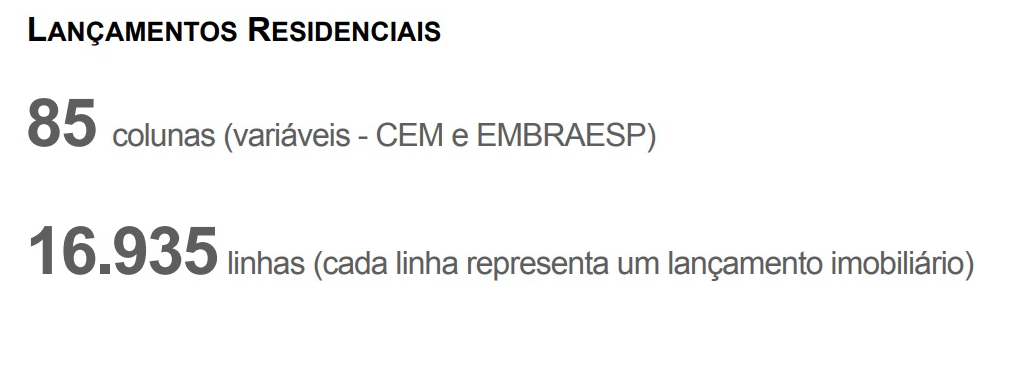
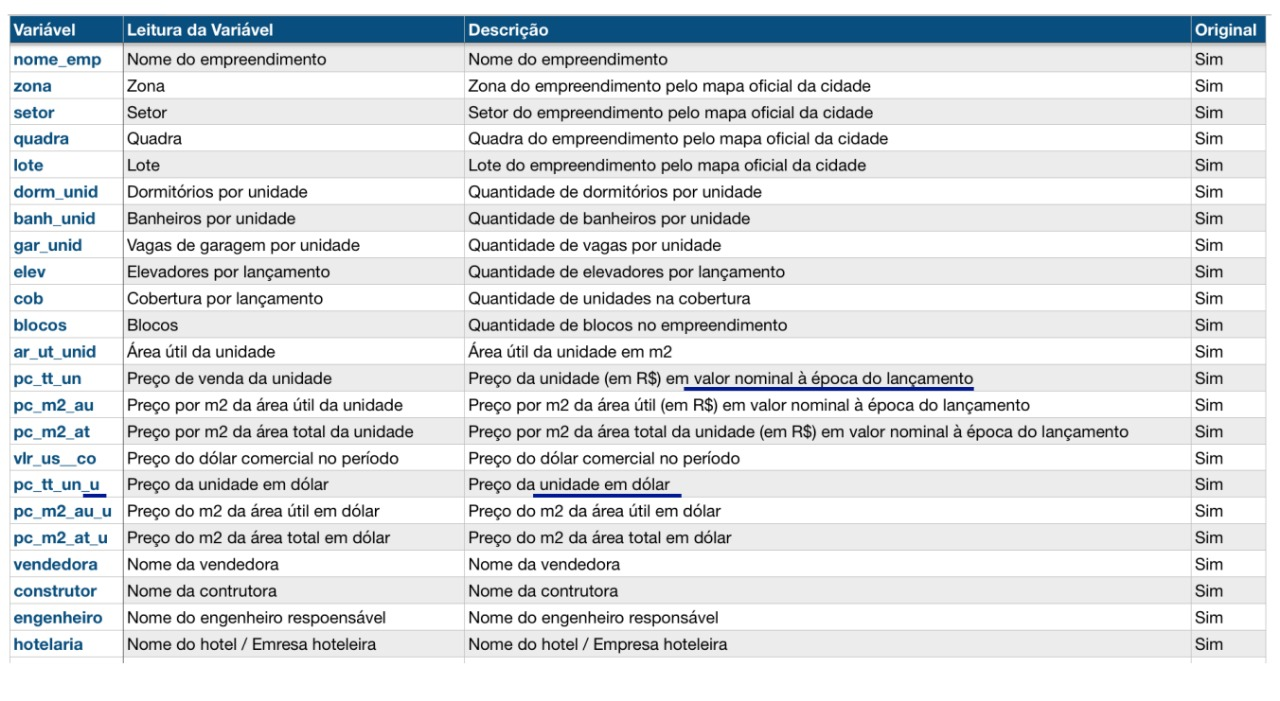
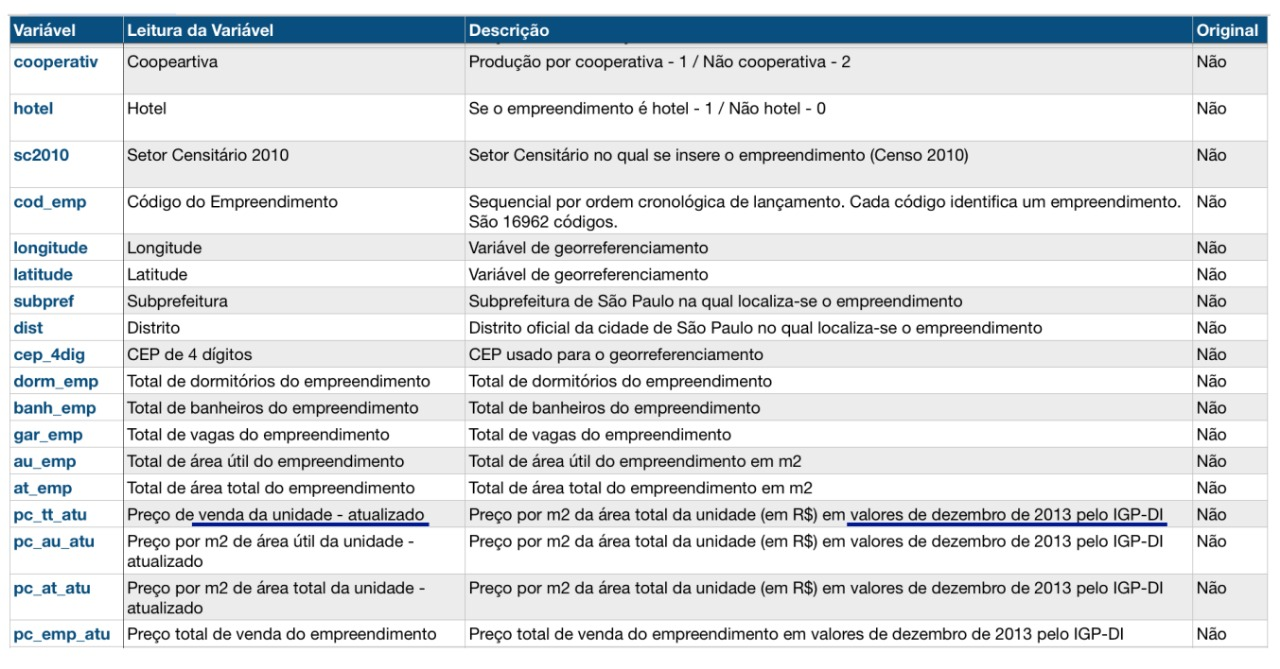
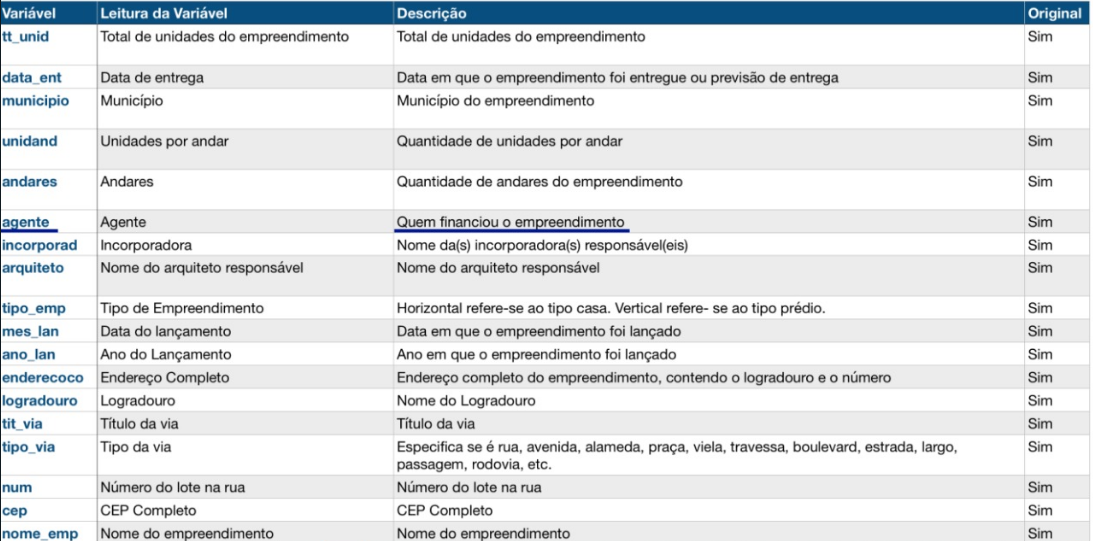
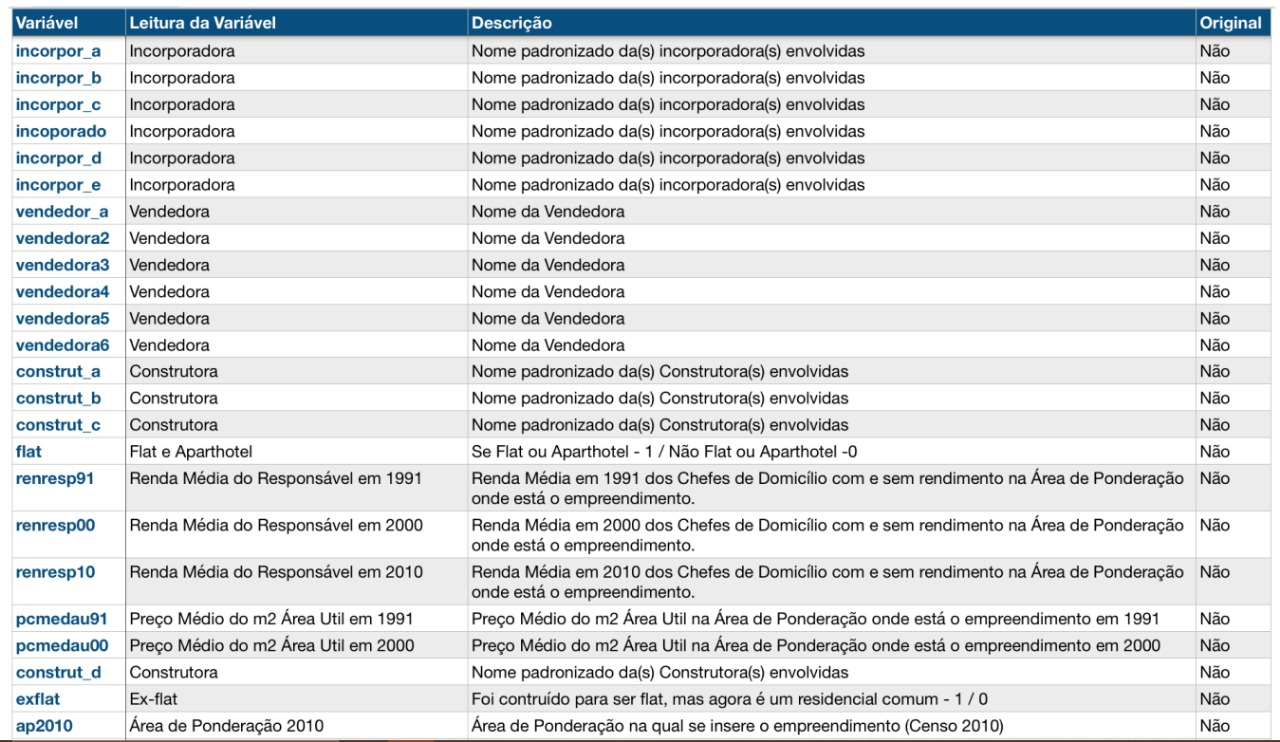

<h3>0.0 Importando as bibliotecas</h3>
<h5>Para mais informações sobre os pré-requisitos visualize o arquivo "requirements" que se encontra no repositório</h5>

In [1]:
#Evitando alguns avisos de erros que atrapalham a leitura do código
import warnings
warnings.filterwarnings("ignore")

#Bibliotecas de importação de dados
import basedosdados as bd

#Manipulação de dados
import pandas as pd
import numpy as np

#Visualização de dados
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

In [2]:
plt.setp(axa.xaxis.get_majorticklabels(), rotation=45)

NameError: name 'axa' is not defined

<h3>0.1 Definindo algumas funções do código</h3>
<h5>Essas são algumas funções que são definidas anteriormente porque são utilizadas recorrentemente no código ou são fruto de trabalhos anteriores</h5>

In [17]:
def plot_hist_variaveis(conjunto, dataframe, i=0):
    total_plots = len(conjunto)
    fig = plt.figure(figsize=(15,90), facecolor='white')
    fig.subplots_adjust(hspace=0.6, wspace=0.3)

    for var in conjunto:
        ax = fig.add_subplot(total_plots, 2, i+1)

        sns.distplot(x=dataframe[var], ax=ax, color='#435058')
        ax.axvline(x=dataframe[var].mean(), linestyle='--', color='red')
        ax.set_title(var + '. Média = {}'.format(round(dataframe[var].mean(), 2)))
        ax.set_ylabel('')
        ax.set_xlabel('')
        i += 1

def plot_violin_variaveis(conjunto, dataframe,resposta, i=0):
    total_plots = len(conjunto)
    fig = plt.figure(figsize=(30,90), facecolor='white')
    fig.subplots_adjust(hspace=0.2, wspace=0.3)

    for var in conjunto:
        ax = fig.add_subplot(total_plots, 2, i+1)

        sns.boxplot(x=dataframe[var], ax=ax, y=dataframe[resposta], color='#435058')
        ax.set_title(var)
        ax.set_ylabel('')
        ax.set_xlabel('')
        plt.xticks(rotation=90)
        #plt.show()
        i += 1

def otimiza_dataframe (dataframe):
    counter_num = 0
    counter_cat = 0
    for col in dataframe.columns:
      if dataframe[col].dtype == 'int64':
          if dataframe[col].max() < 2**7 and dataframe[col].min() > -(2**7):
            dataframe[col] = dataframe[col].astype(np.int8) 
            counter_num += 1 
          elif dataframe[col].max() < 2**15 and dataframe[col].min() > -(2**15):
            dataframe[col] = dataframe[col].astype(np.int16)  
            counter_num += 1 
          elif dataframe[col].max() < 2**31 and dataframe[col].min() > -(2**31):
            dataframe[col] = dataframe[col].astype(np.int32)  
            counter_num += 1 
          elif dataframe[col].max() < 2**63 and dataframe[col].min() > -(2**63):
            dataframe[col] = dataframe[col].astype(np.int64) 
            counter_num += 1    

      elif dataframe[col].dtype == 'float64': 
          if dataframe[col].max() < 2**31 and dataframe[col].min() > -(2**31):
            dataframe[col] = dataframe[col].astype(np.float32)
            counter_num += 1 

      elif dataframe[col].dtype == 'object':
        dataframe[col] = dataframe[col].astype('category')
        counter_cat += 1
    print('Foram otimizadas {} variáveis numéricas e  {} variáveis categóricas'.format(counter_num, counter_cat))



    

<h3>1. Lendo e ajustando as bases</h3>
<h5>A base da EMBRAESP contém, sozinha, uma série de informações úteis sobre o mercado imobiliário residencial na cidade mas achou-se proveitosa a conexão com algumas bases do Censo Demográfico de 2010, a fim de elaborar uma compreensão melhor sobre o quadro temático de onde os edifícios lançados se encontram. Todas as bases do Censo foram obtidas diretamente do diretório do Base de Dados</h5>

In [5]:
#Obtendo o dataframe do Censo Demográfico (Básico) a partir da Base dos Dados
'''df_censo_basico = bd.read_table(dataset_id='br_ibge_censo_demografico',
table_id='setor_censitario_basico_2010', billing_project_id="229299106527")'''

df_censo = pd.read_csv('CENSO_2010_TRABALHADO.csv')

In [7]:
df_censo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310120 entries, 0 to 310119
Data columns (total 17 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   Unnamed: 0                                      310120 non-null  int64  
 1   id_setor_censitario                             310120 non-null  int64  
 2   Domicílios_Setor                                309347 non-null  float64
 3   Média_Moradores_por_domicilio_setor             309347 non-null  float64
 4   Média_Renda_Responsaveis_Setor                  309347 non-null  float64
 5   Domicilios no setor censitário                  310120 non-null  int64  
 6   Domicilios alugados                             303818 non-null  float64
 7   Domicilios unipessoais                          303818 non-null  float64
 8   Domicilios 2 ou 3 moradores                     303818 non-null  float64
 9   Domicilios 4 ou mais morad

In [4]:
#Selecionando no dataframe do Censo demográfico apenas os dados de São Paulo. SP1 = São Paulo/SP, SP2 = Demais regiões do Estado.
#estado = ['SP1', 'SP2']
#df_censo_basico = df_censo_basico[df_censo_basico['sigla_uf'].isin(estado)]

In [8]:
#Lendo os dados da EMBRAESP
path = "LANRES_85_13_RMSP_CEM.csv"
df = pd.read_csv(path, delimiter=';', decimal=',')

<h3>1.1 Pré tratamento das bases</h3>
<h5>Alguns pré-tratamentos das duas bases, envolvendo a modificação de tipos das colunas (para facilitar a intersecção posterior entre elas) e a remoção de colunas que não são consideradas úteis para a análise, além do preenchimento de valores nulos</h5>

In [9]:
#Compatibilizando os tipos da coluna que vai servir de join entre os dataframes e renomeando algumas variáveis para facilitar a interpretação
df_censo['id_setor_censitario'] = df_censo['id_setor_censitario'].astype('int64')
#df_censo = df_censo.rename({'v001':'Domicílios_Setor', 'v003':'Média_Moradores_por_domicilio_setor', 'v005':'Média_Renda_Responsaveis_Setor'}, axis=1)

In [10]:
#Removendo colunas categóricas com dados muito fragmentados e que não oferecem boa leitura pela alto grau de cardinalidade 
df = df.drop(['NOME_EMP','CEP','SETOR', 'QUADRA', 'LOTE', 'COD_EMP', 'ENDERECOCO', 'LOGRADOURO', 'TIT_VIA', 'NUM','CEP_4DIG', 'ENGENHEIRO', 'ARQUITETO', 'HOTELARIA', 'INCOPORADO'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16935 entries, 0 to 16934
Data columns (total 70 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          16935 non-null  int64  
 1   TIPO_EMP    16935 non-null  object 
 2   MES_LAN     16935 non-null  object 
 3   ANO_LAN     16935 non-null  int64  
 4   DATA_ENT    16935 non-null  object 
 5   DIST        13234 non-null  object 
 6   SUBPREF     13234 non-null  object 
 7   MUNICIPIO   16935 non-null  object 
 8   TIPO_VIA    16929 non-null  object 
 9   ZONA        16935 non-null  object 
 10  DORM_UNID   16935 non-null  int64  
 11  BANH_UNID   16935 non-null  int64  
 12  GAR_UNID    16935 non-null  int64  
 13  ELEV        16935 non-null  int64  
 14  COB         16935 non-null  int64  
 15  BLOCOS      16935 non-null  int64  
 16  UNIDAND     16935 non-null  int64  
 17  ANDARES     16935 non-null  int64  
 18  AR_UT_UNID  16935 non-null  float64
 19  AR_TT_UNID  16935 non-nul

In [11]:
#Removendo colunas de incorporadora, vendedoras e construtoras secundárias no processo dos edifícios. Na maior parte das linhas só há dados para os agentes primários e os agentes secundários tem muitos nulos
remover = []
for col in df.columns:
    for nome in ['INCORPOR_', 'VENDEDOR', 'CONSTRUT_']:
        remover.append(col) if nome in col and col != ('INCORPOR_A' or 'CONSTRUT_A') else None

#por algum motivo uma variável a mais entrou na lista de remoção, vou remover na mão e depois checo o porquê disso
remover.remove('CONSTRUT_A')
df = df.drop(remover, axis=1)

In [12]:
#Índice de banheiros por dormitório, um índice 1 ou maior pode indicar que todos os quartos são suítes (exceto para casos de 1 dormitório apenas)
df['BANH_DORM'] = df['BANH_UNID']/df['DORM_UNID']

#As variáveis de distrito e subprefeitura só fazem menção aos locais dentro da cidade de São Paulo, então coloquei os valores nulos como "Fora de São Paulo", apenas para facilitar a manipulação posterior
df[['DIST', 'SUBPREF']] = df[['DIST', 'SUBPREF']].fillna('FORA-SP')

#Essas colunas possuiam poucos valores nulos, que foram preenchidos com a mediana de todo o conjunto de dados em cada coluna
for col in ['RENRESP91', 'PCMEDAU91', 'PCMEDAU00','PCMEDAU10']:
    df[col] = df[col].fillna(df[col].median())

#Colunas numéricas que na verdade são categóricas
for col in ['COOPERATIV', 'HOTEL', 'FLAT', 'EXFLAT']:
    df[col] = df[col].astype(dtype='category')

<h3>1.2 Junção das bases</h3>
<h5>A conexão das bases é realizada a partir do setor censitário, logo, as informações captadas do Censo dizem respeito a todo o setor censitário ao qual o empreendimento está inserido, um setor censitário pode conter (e normalmente contém) mais de um empreendimento. O Censo do IBGE possui uma infinidade de variáveis e foram selecionadas apenas algumas que dão uma visão geral sobre o setor.</h5>

In [13]:
#Juntando a base da EMBRAESP e a(s) base(s) do Censo a partir dos setores censitários
df = df.join(df_censo.set_index('id_setor_censitario'), on='SC_2010', how='left')

In [15]:
df.shape

(16935, 73)

In [18]:
#Os dados das colunas são pesados e a otimização dos dataframes leva em consideração o tamanho dos números em cada coluna para converter a um dtype adequado, visando diminuir o peso.
otimiza_dataframe(df)

Foram otimizadas 55 variáveis numéricas e  14 variáveis categóricas


In [70]:
df.columns

Index(['ID', 'TIPO_EMP', 'MES_LAN', 'ANO_LAN', 'DATA_ENT', 'DIST', 'SUBPREF',
       'MUNICIPIO', 'TIPO_VIA', 'ZONA', 'DORM_UNID', 'BANH_UNID', 'GAR_UNID',
       'ELEV', 'COB', 'BLOCOS', 'UNIDAND', 'ANDARES', 'AR_UT_UNID',
       'AR_TT_UNID', 'AR_TT_TERR', 'TT_UNID', 'DORM_EMP', 'BANH_EMP',
       'GAR_EMP', 'AU_EMP', 'AT_EMP', 'PC_TT_UN', 'PC_M2_AU', 'PC_M2_AT',
       'PC_TT_ATU', 'PC_AU_ATU', 'PC_AT_ATU', 'PC_EMP_ATU', 'VLR_US__CO',
       'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'SIST_FINAN', 'AGENTE',
       'INCORPORAD', 'CONSTRUTOR', 'INCORPOR_A', 'CONSTRUT_A', 'COOPERATIV',
       'HOTEL', 'FLAT', 'EXFLAT', 'AP2010', 'SC_2010', 'RENRESP91',
       'RENRESP00', 'RENRESP10', 'PCMEDAU91', 'PCMEDAU00', 'PCMEDAU10',
       'BANH_DORM', 'Unnamed: 0', 'Domicílios_Setor',
       'Média_Moradores_por_domicilio_setor', 'Média_Renda_Responsaveis_Setor',
       'Domicilios no setor censitário', 'Domicilios alugados',
       'Domicilios unipessoais', 'Domicilios 2 ou 3 moradores',
      

<h3>2. Definição das variáveis e análises visuais</h3>

<h5>São definidas as variáveis resposta (que será utilizada posteriormente no modelo de Machine Learning), bem como as variáveis numéricas e categóricas. A definição dessas variáveis ajuda na visualização dos dados e na execução dos pipelines</h5>

In [74]:
#A variável resposta é o Preço do M² da unidade a partir do valor atualizado de 2013. A divisão entre varia´veis int e float é apenas para possíveis questões de performance
v_resposta = "PC_AT_ATU"
v_numericos = df.select_dtypes(include=["int8", "int16", "int32", "int64", "float"]).columns.to_list()
v_int = df.select_dtypes(include=["int8", "int16", "int32", "int64"]).columns.to_list()
v_float = df.select_dtypes(include="float").columns.to_list()
v_censo = ['Domicílios_Setor',
       'Média_Moradores_por_domicilio_setor', 'Média_Renda_Responsaveis_Setor',
       'Domicilios no setor censitário', 'Domicilios alugados',
       'Domicilios unipessoais', 'Domicilios 2 ou 3 moradores',
       'Domicilios 4 ou mais moradores', 'Residentes no setor censitário',
       'Brancos', 'Pretos', 'Amarelos', 'Pardos', 'Índigenas',
       'Total de filhos dos responsáveis de domicílios']

[v.remove(v_resposta) for v in [v_numericos]]
[v.remove('ID') for v in [v_numericos]]

v_categoricos = ['TIPO_EMP', 'DIST', 'SUBPREF', 'MUNICIPIO', 'TIPO_VIA', 'ZONA', 'SIST_FINAN', 'AGENTE']
#df.select_dtypes(include="category").columns.to_list()
v_datas = ['MES_LAN', 'DATA_ENT']
#v_categoricos.remove('MES_LAN') 
#v_categoricos.remove('DATA_ENT') 

In [14]:
#Recortando o ambiente de análise, selecionando apenas empreendimentos dentro da cidade de São Paulo
df_sp = df.query("MUNICIPIO == 'SAO PAULO'")

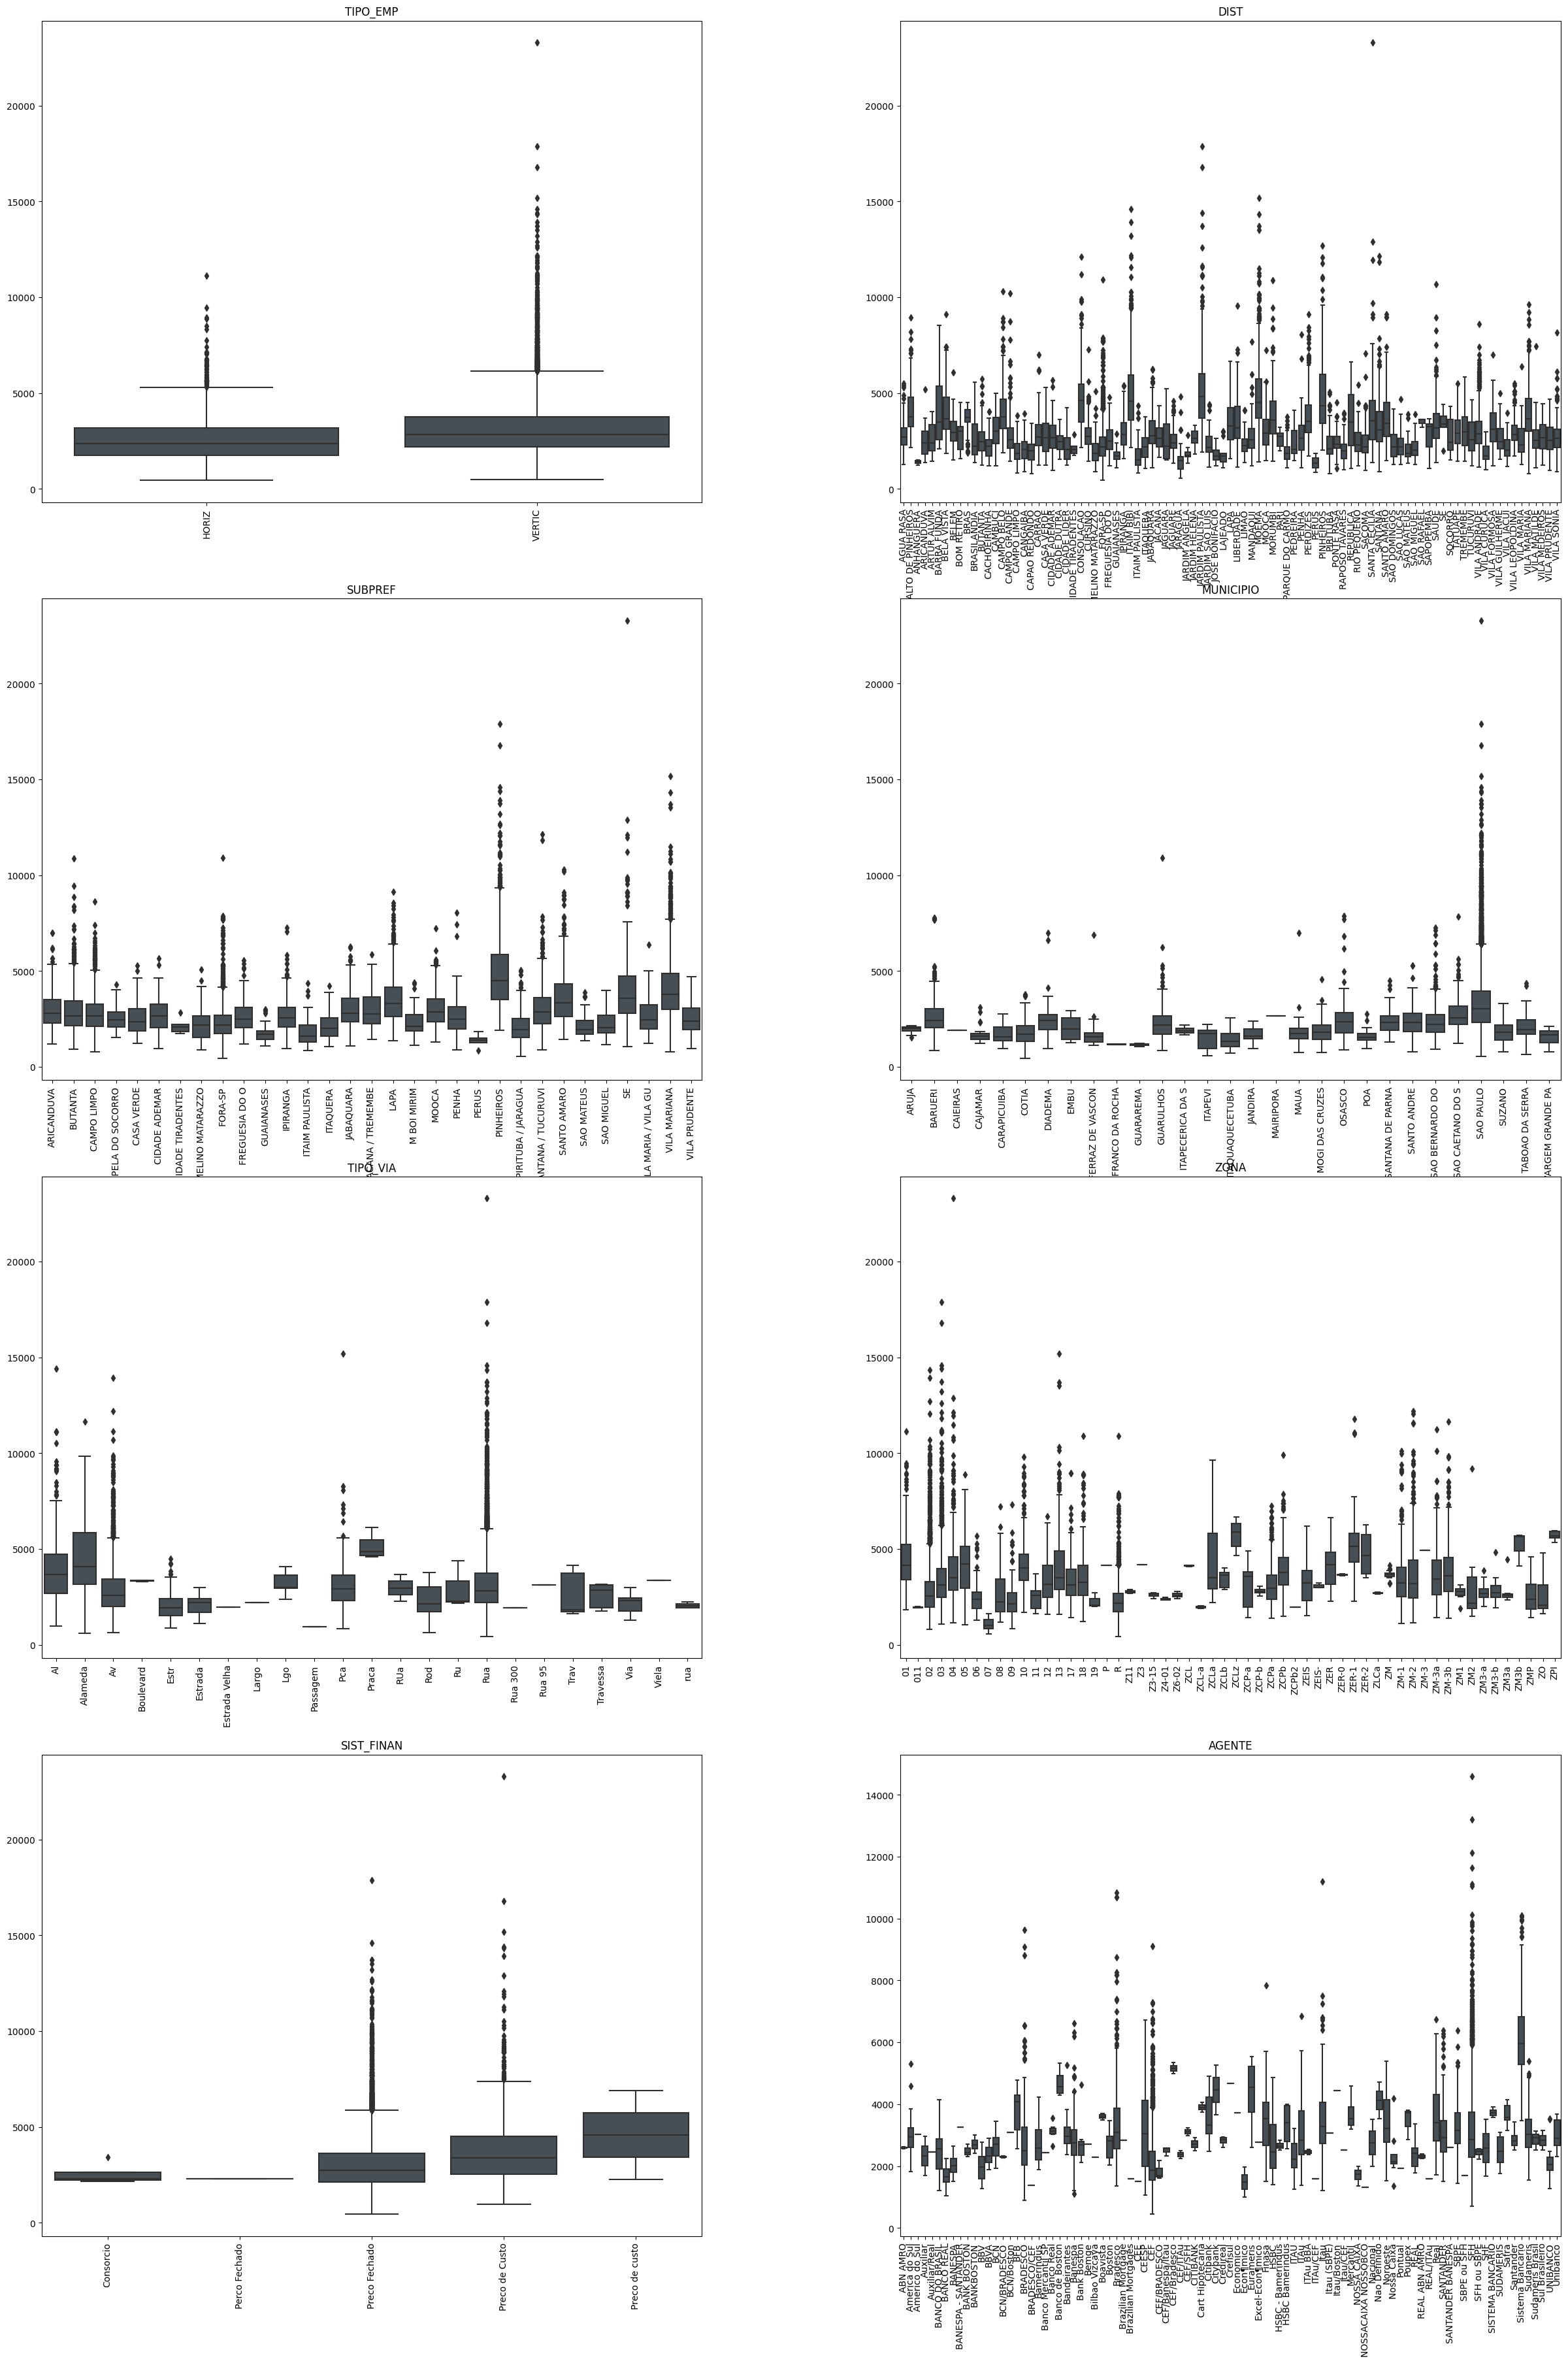

In [21]:
plot_violin_variaveis(dataframe=df, conjunto=v_categoricos, resposta=v_resposta)

In [22]:
for col in df[v_numericos].columns:
    limite = df[col].quantile(0.95)
    df[col] = df[col].where(df[col] < limite, limite)

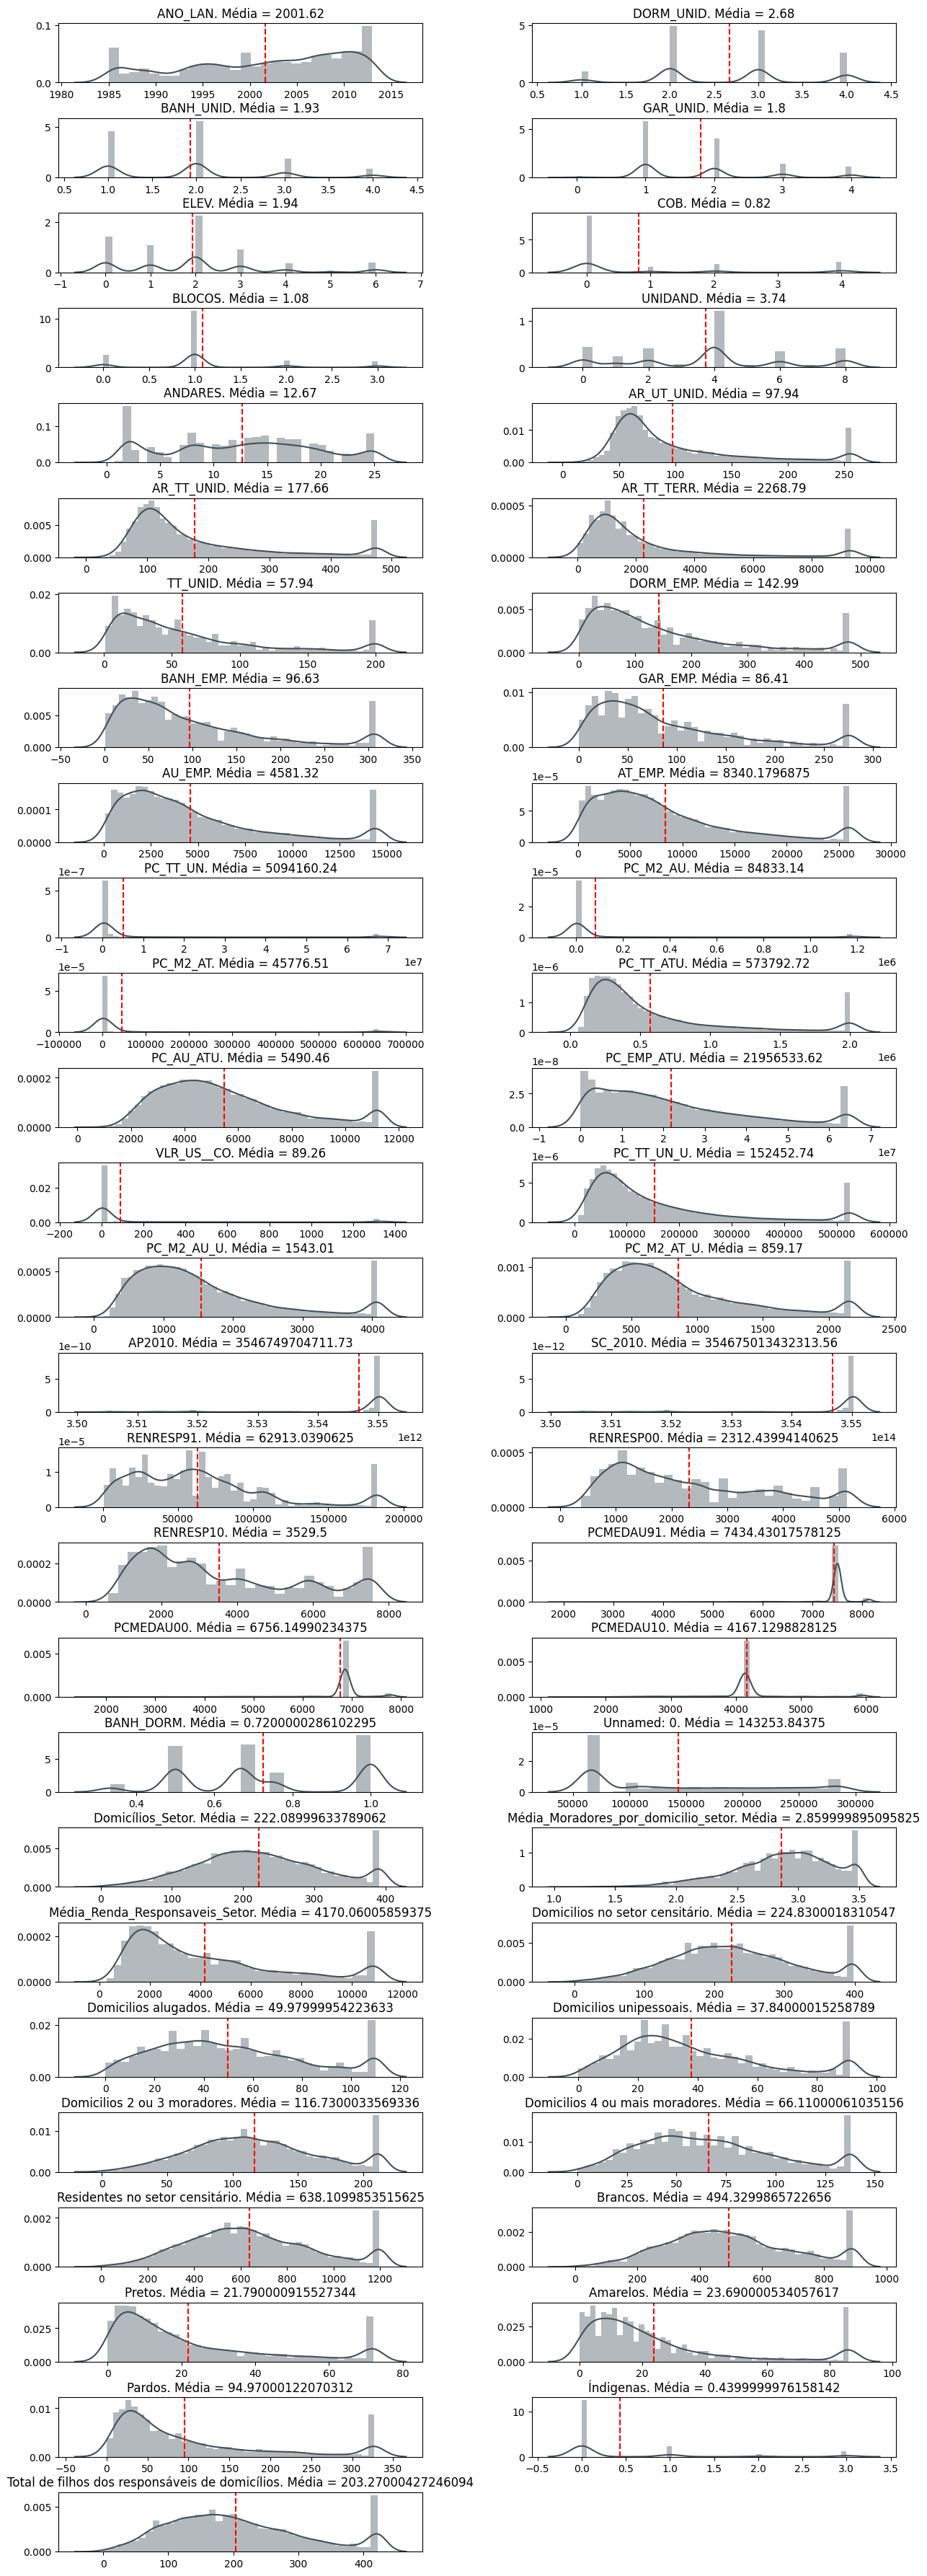

In [23]:
plot_hist_variaveis(v_numericos, df)

In [40]:
df[v_numericos].describe()

ANO_LAN     DORM_UNID     BANH_UNID      GAR_UNID          ELEV  \
count  16935.000000  16935.000000  16935.000000  16935.000000  16935.000000   
mean    2001.621081      2.675465      1.929200      1.804901      1.938057   
std        8.376523      0.873354      0.878335      0.967568      1.580896   
min     1985.000000      1.000000      1.000000      0.000000      0.000000   
25%     1995.000000      2.000000      1.000000      1.000000      1.000000   
50%     2003.000000      3.000000      2.000000      2.000000      2.000000   
75%     2009.000000      3.000000      2.000000      2.000000      3.000000   
max     2013.000000      4.000000      4.000000      4.000000      6.000000   

                COB        BLOCOS       UNIDAND       ANDARES    AR_UT_UNID  \
count  16935.000000  16935.000000  16935.000000  16935.000000  16935.000000   
mean       0.816120      1.083141      3.744553     12.674579     97.939367   
std        1.397905      0.725733      2.436496      6.915234     58.990681   
min        0.000000      0.000000      0.000000      0.000000     12.720000   
25%        0.000000      1.000000      2.000000      8.000000     57.680000   
50%        0.000000      1.000000      4.000000     13.000000     74.000000   
75%        1.000000      1.000000      6.000000     18.000000    120.000000   
max        4.000000      3.000000      8.000000     25.000000    256.335992   

       ...  PC_M2_AT_log  VLR_US__CO_log  PCMEDAU10_log  PC_AT_ATU_log  \
count  ...  16935.000000    16935.000000   16935.000000   16935.000000   
mean   ...      8.010491        1.436512       8.323695       7.946780   
std    ...      1.811888        1.876062       0.153140       0.423592   
min    ...      4.702206        0.000000       7.232264       6.094901   
25%    ...      6.901843        0.693147       8.328303       7.666489   
50%    ...      7.462382        0.693147       8.328303       7.929332   
75%    ...      8.228942        1.098612       8.328303       8.213957   
max    ...     13.365802        7.188413       8.690370      10.056048   

       PC_TT_UN_log  PC_M2_AU_log  PC_M2_AT_log  VLR_US__CO_log  \
count  16935.000000  16935.000000  16935.000000    16935.000000   
mean      12.991393      8.588031      8.010491        1.436512   
std        1.839429      1.833668      1.811888        1.876062   
min       10.110502      5.323839      4.702206        0.000000   
25%       11.733758      7.457442      6.901843        0.693147   
50%       12.517227      8.031135      7.462382        0.693147   
75%       13.547664      8.828345      8.228942        1.098612   
max       18.030761     13.980308     13.365802        7.188413   

       PCMEDAU10_log  PC_AT_ATU_log  
count   16935.000000   16935.000000  
mean        8.323695       7.946780  
std         0.153140       0.423592  
min         7.232264       6.094901  
25%         8.328303       7.666489  
50%         8.328303       7.929332  
75%         8.328303       8.213957  
max         8.690370      10.056048  

[8 rows x 65 columns]

In [41]:
df_zero = df.loc[df['PC_TT_UN'] == 0]
df_zero.shape #118 colunas com preço da unidade igual a 0

(0, 80)

In [42]:
df['PC_TT_UN'].replace(0,df['PC_TT_UN'].mean(axis=0),inplace=True)
df['PC_TT_UN'].describe()

count    1.693500e+04
mean     5.129655e+06
std      1.571667e+07
min      2.460000e+04
25%      1.247115e+05
50%      2.730000e+05
75%      7.650250e+05
max      6.771115e+07
Name: PC_TT_UN, dtype: float64

In [58]:
v_resposta

'PC_AT_ATU'

In [59]:
v_precos = ['PC_TT_UN', 'PC_M2_AU', 'PC_M2_AT', 'VLR_US__CO', 'PCMEDAU10', v_resposta]

for col in v_precos:
    #df[col] = df[col].where(df[col] == 0, 0.0001)
    df[col+'_log'] = np.log(df[col])
    v_numericos.append(col+'_log')

v_resposta_log = 'PC_AT_ATU_log'


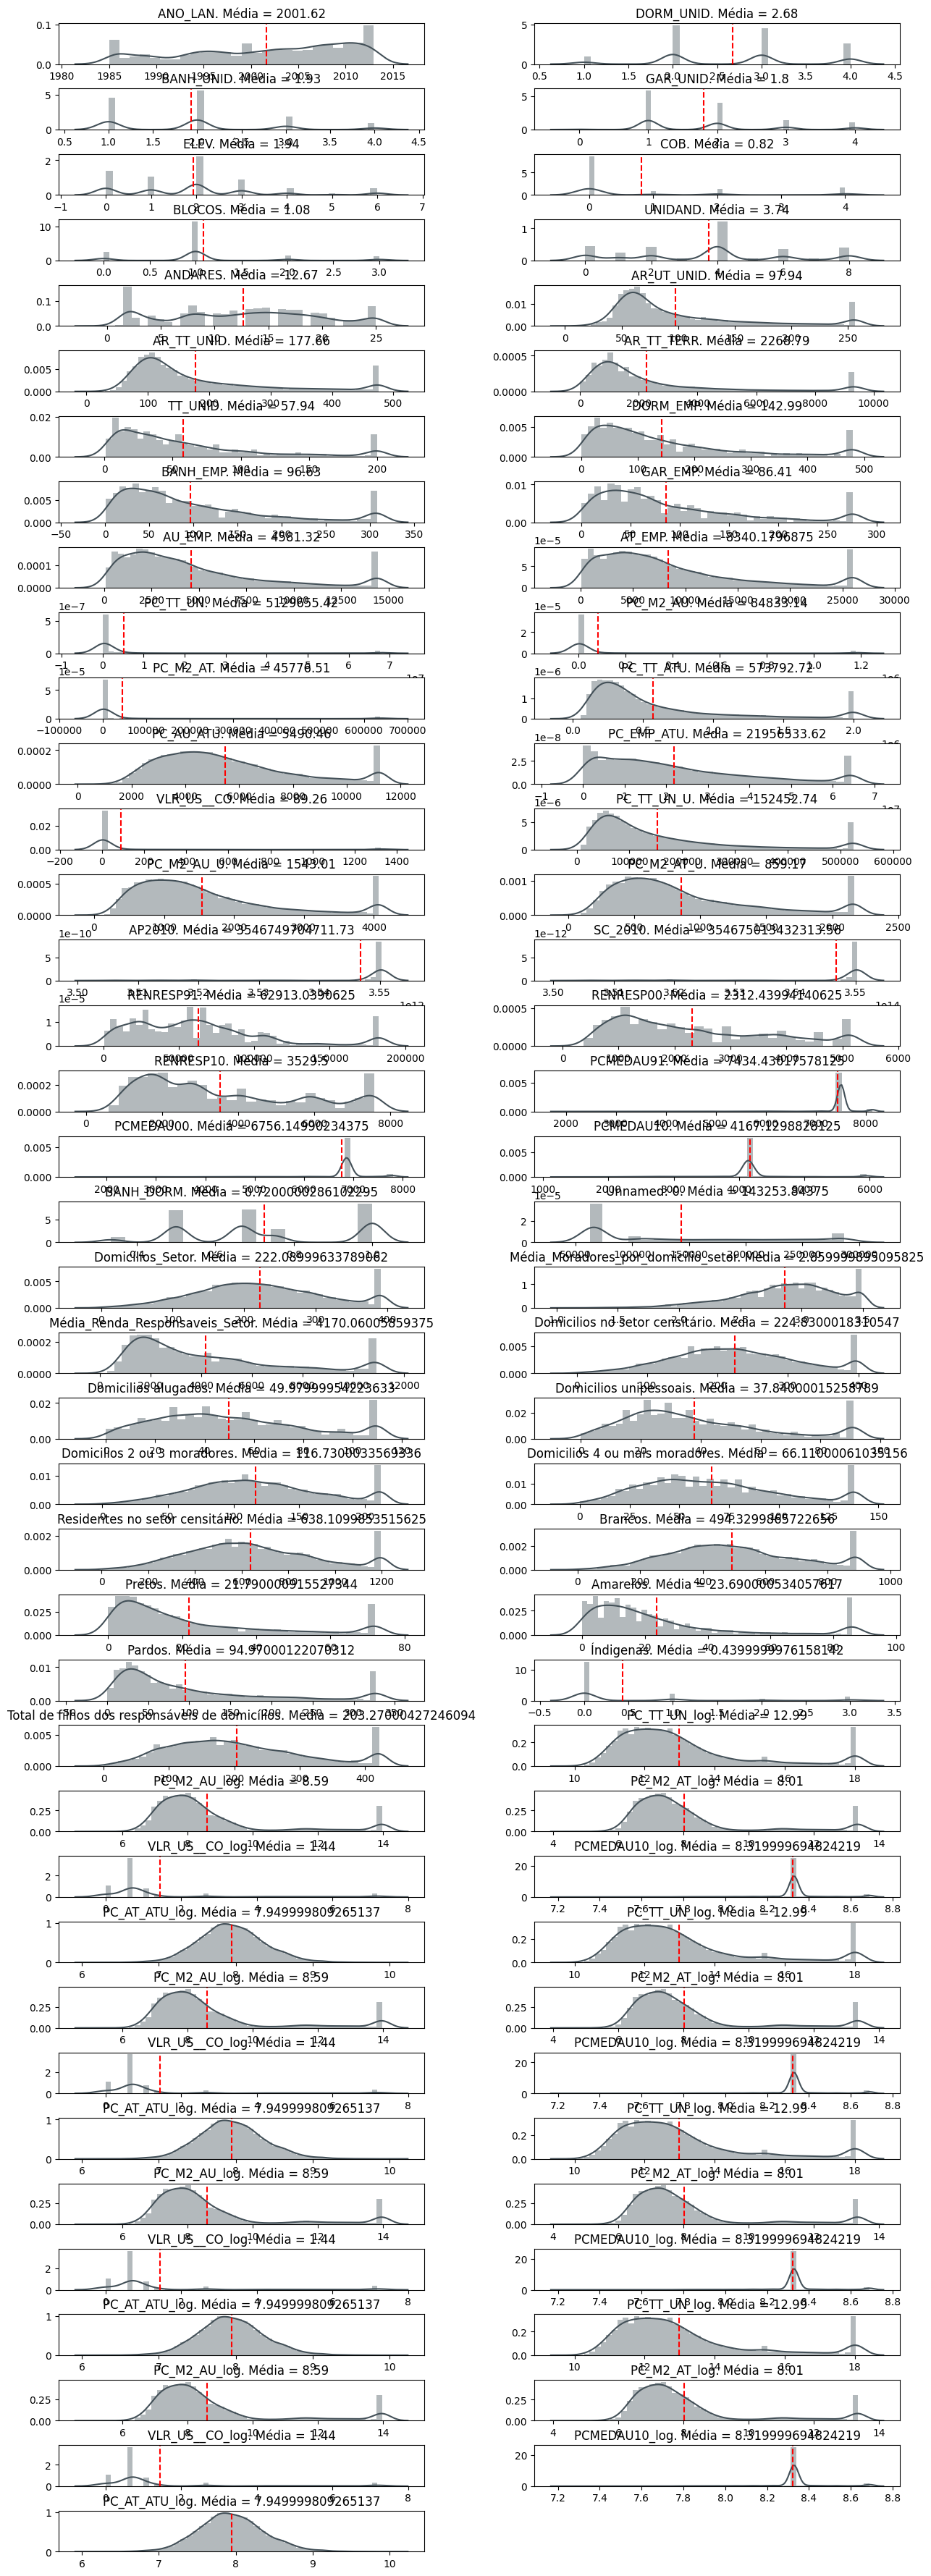

In [60]:
plot_hist_variaveis(v_numericos, df)

<h3>3. Análises Bivariadas</h3>

<h5>Para facilitar a distinção geográfica, as subprefeituras de São Paulo foram agrupadas a partir de cada uma das regiões previstas pela divisão municipal</h5>

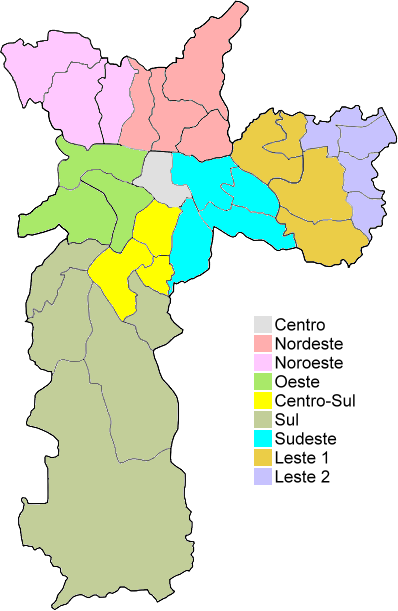

In [54]:
#Criando uma nova variável que categoriza cada linha em sua região a partir de seu distrito
regioes = {'Centro': ['SE'],
           'Nordeste': ['CASA VERDE', 'SANTANA / TUCURUVI', 'VILA MARIA / VILA GU', 'JACANA / TREMEMBE'],
           'Noroeste': ['FREGUESIA DO O ', 'PIRITUBA / JARAGUA', 'PERUS'],
           'Oeste': ['BUTANTA', 'PINHEIROS', 'LAPA'],
           'Centro-Sul': ['VILA MARIANA', 'JABAQUARA', 'SANTO AMARO'],
           'Sul': ['CAMPO LIMPO', 'M BOI MIRIM', 'PARELHEIROS', 'CAPELA DO SOCORRO', 'CIDADE ADEMAR'],
           'Sudeste': ['IPIRANGA', 'VILA PRUDENTE', 'ARICANDUVA', 'MOOCA'],
           'Leste 1': ['PENHA', 'ERMELINO MATARAZZO', 'ITAQUERA', 'SAO MATEUS'],
           'Leste 2': ['SAO MIGUEL', 'ITAIM PAULISTA', 'GUAIANASES', 'CIDADE TIRADENTES'],
           'RMSP': ['FORA-SP']
}

regioes = {valor:chave for chave, lista in regioes.items() for valor in lista}
df['REGIAO'] = df['SUBPREF'].map(regioes)

<h3>3.1 - Quantificando os lançamentos imobiliários por região de São Paulo</h3> 

<h4>3.1.1 - Verificando o valor dos empreendimentos e do m² em cada região</h4>
<h5>Há um disparidade entre o número de lançamentos por região em São Paulo. As regiões oeste e centro-sul concentram a grande parte dos empreendimentos, enquanto as zonas leste e norte tiveram um número de lançamentos comparativamente muito menor. Verifica-se que os locais de maior número de lançamentos imobiliários se confundem com os de maiores valores do empreendimento e do m², de maneira semelhante, os empreendimentos lançados nas regiões norte e leste possuem valor de mercado relativamente menor</h5>

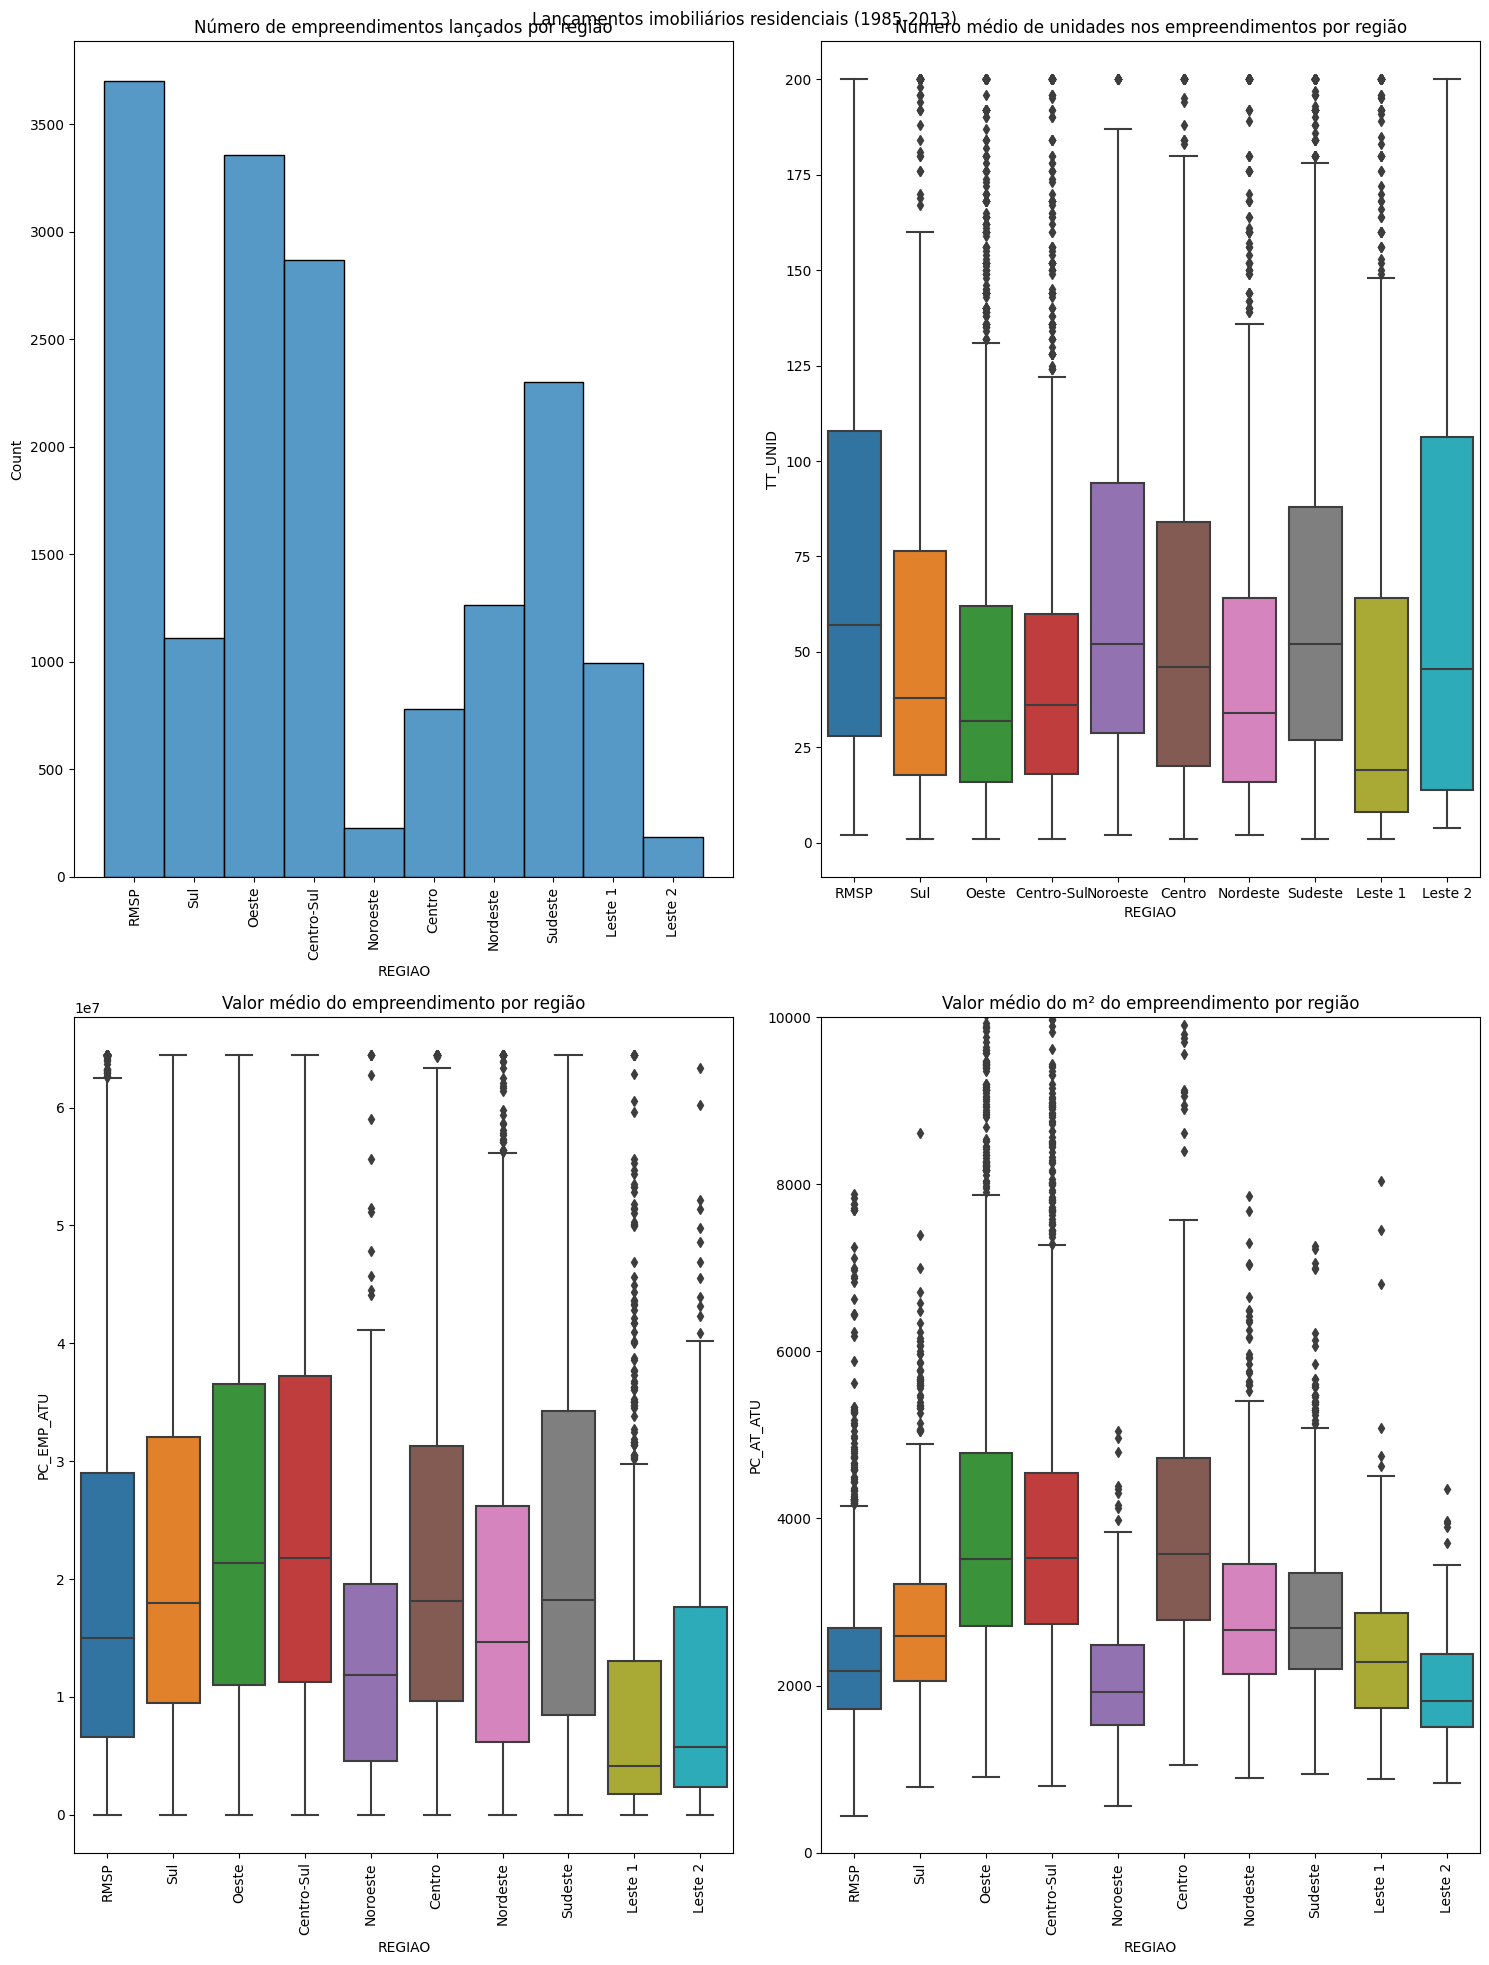

In [63]:
#Plotando as figuras dos gráficos relacionados ao valor dos empreenidmentos
fig, axs = plt.subplots(figsize=(15,20), ncols=2, nrows=2, facecolor='white')
n_emp_regiao = sns.histplot(x='REGIAO', data=df, ax=axs[0][0])
n_unid_emp = sns.boxplot(x='REGIAO', y='TT_UNID', data=df, ax=axs[0][1])
pc_emp_regiao = sns.boxplot(x='REGIAO', y='PC_EMP_ATU', data=df, ax=axs[1][0])
pc_m2_regiao = sns.boxplot(x='REGIAO', y=v_resposta, data=df, ax=axs[1][1])

n_emp_regiao.set_title('Número de empreendimentos lançados por região')
n_unid_emp.set_title('Número médio de unidades nos empreendimentos por região')
pc_emp_regiao.set_title('Valor médio do empreendimento por região')
pc_m2_regiao.set_title('Valor médio do m² do empreendimento por região')

plt.xticks(rotation=90)
n_emp_regiao.tick_params('x', labelrotation=90)
pc_emp_regiao.tick_params('x', labelrotation=90)
pc_m2_regiao.set_ylim(0,10000)

plt.suptitle('Lançamentos imobiliários residenciais (1985-2013)')
plt.tight_layout()

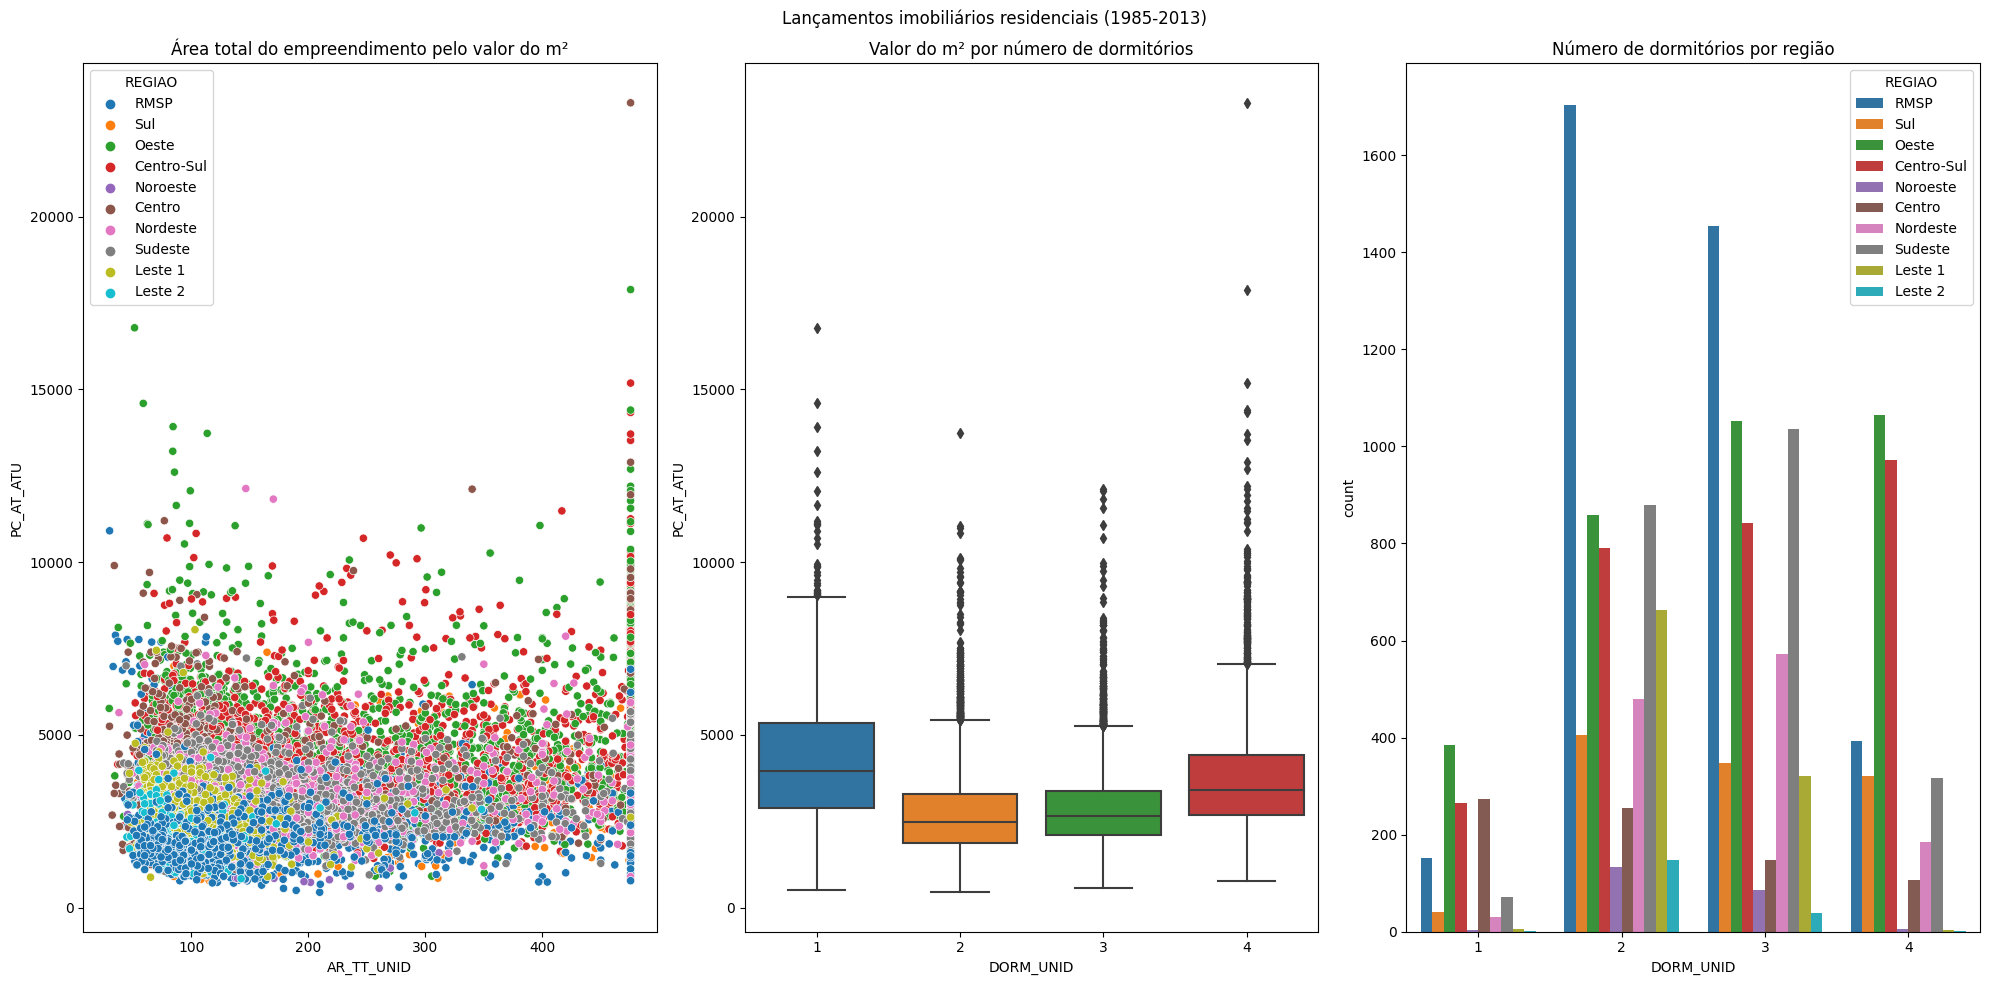

In [47]:
fig, axs = plt.subplots(figsize=(20,10), ncols=3, nrows=1, facecolor='white')
area_pc = sns.scatterplot(x='AR_TT_UNID', y=v_resposta, hue='REGIAO', data=df, ax=axs[0])
m2_dorm = sns.boxplot(x='DORM_UNID', y=v_resposta, data=df, ax=axs[1])
pc_m2_regiao = sns.countplot(x=df['DORM_UNID'], hue='REGIAO', data=df)

axs[0].set_title('Área total do empreendimento pelo valor do m²')
axs[1].set_title('Valor do m² por número de dormitórios')
axs[2].set_title('Número de dormitórios por região')

plt.suptitle('Lançamentos imobiliários residenciais (1985-2013)')
plt.tight_layout()

In [48]:
#Dataframes com os filters de cada região
df_sul = df.query('REGIAO == "Sul"')
df_noroeste = df.query('REGIAO == "Noroeste"')
df_nordeste = df.query('REGIAO == "Nordeste"')
df_centrosul = df.query('REGIAO == "Centro-Sul"')
df_sudeste = df.query('REGIAO == "Sudeste"')
df_leste1 = df.query('REGIAO == "Leste 1"')
df_oeste = df.query('REGIAO == "Oeste"')
df_centro = df.query('REGIAO == "Centro"')
df_leste2 = df.query('REGIAO == "Leste 2"')


In [68]:
#Função que plota 
def m2_dorm_regiao (lista_dataframes):
    for i, dataframe in enumerate(lista_dataframes):
        fig, axs = plt.subplots(figsize=(20,10), ncols=3, nrows=1, facecolor='white')
        area_pc_regiao = sns.scatterplot(x='AR_TT_UNID', y=v_resposta, hue='REGIAO', data=dataframe, ax=axs[0])
        dorm_unid_pc_box = sns.boxplot(x='DORM_UNID', y=v_resposta, data=dataframe, ax=axs[1])
        num_dorm = sns.countplot(x='DORM_UNID', hue='REGIAO', data=dataframe)

        axs[0].set_title('Área total da unidade pelo valor do m²')
        axs[1].set_title('Valor do m² por número de dormitórios')
        axs[2].set_title('Número de dormitórios por região')

        axs[0].set_ylim(0, 6000)
        axs[1].set_ylim(0, 10000)
        axs[2].set_ylim(0, 1500)
        plt.xticks(rotation=90)
        plt.suptitle('Lançamentos imobiliários residenciais (1985-2013) em {}'.format(dataframe['REGIAO'].mode()))
        plt.tight_layout()

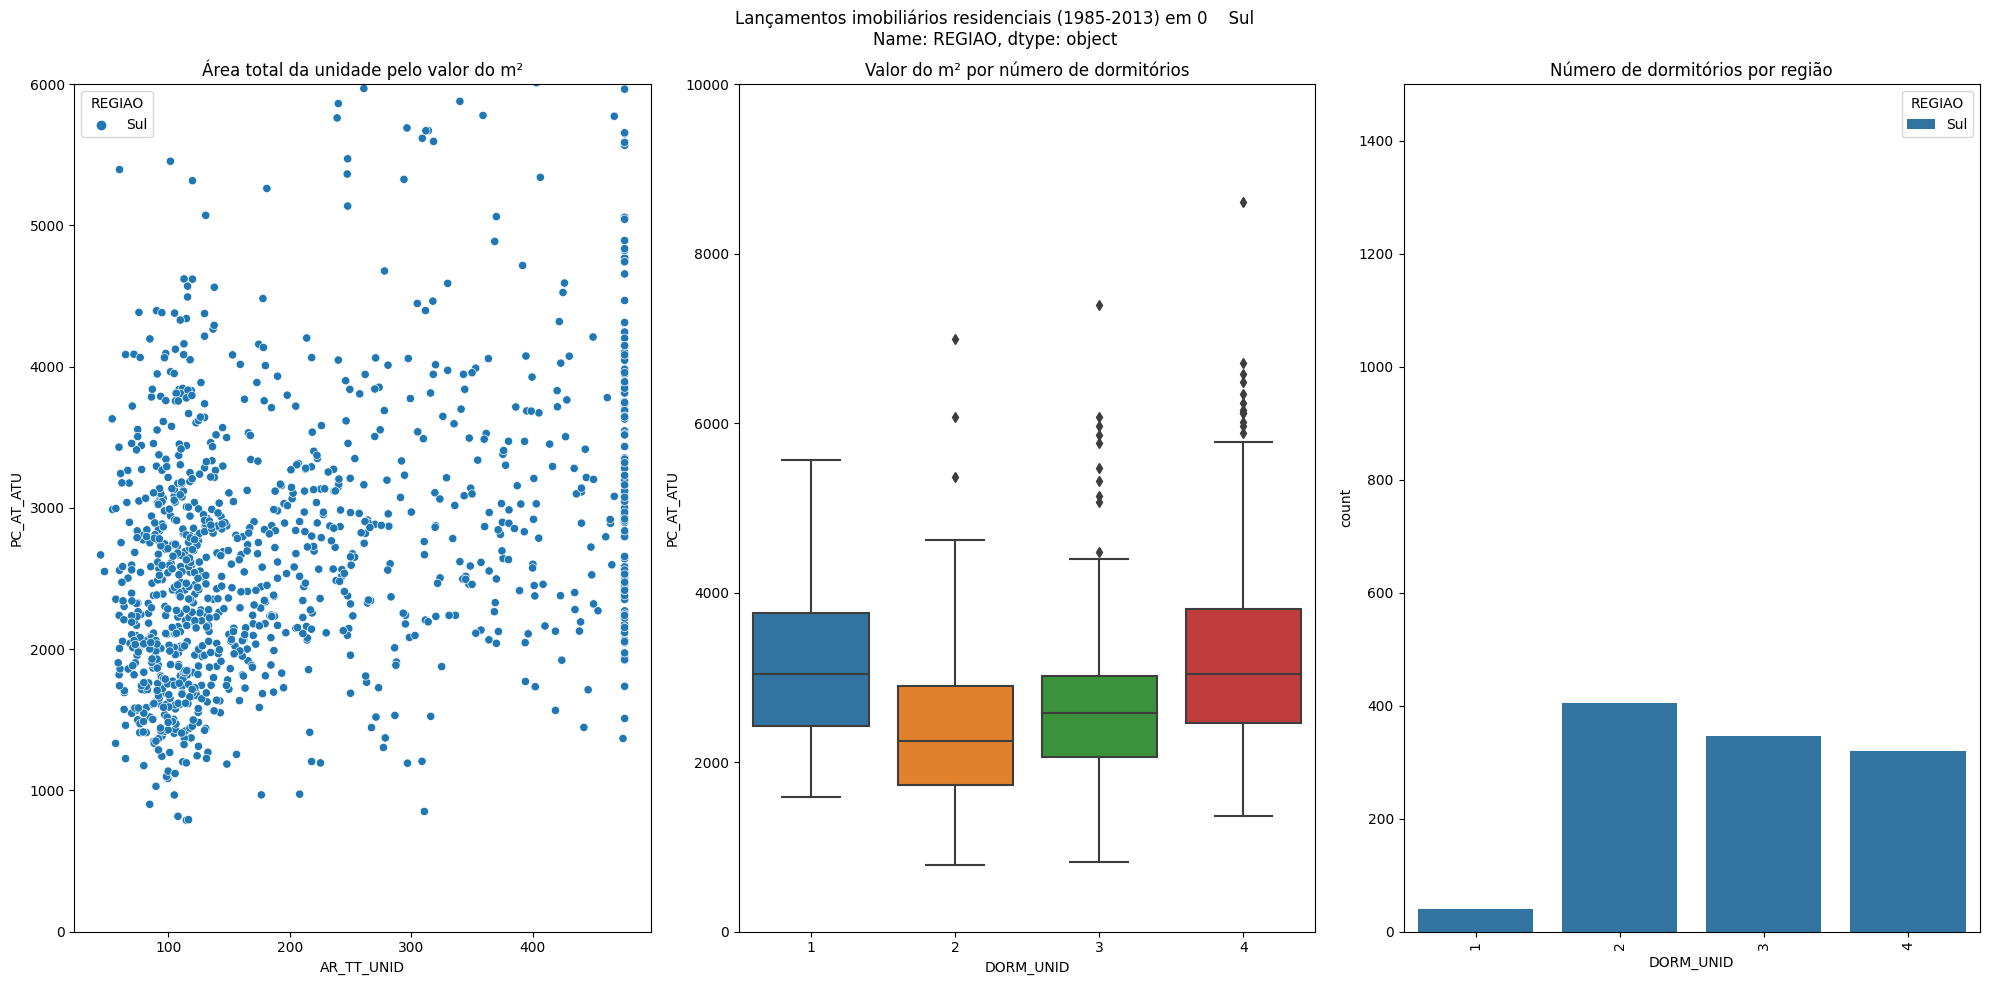

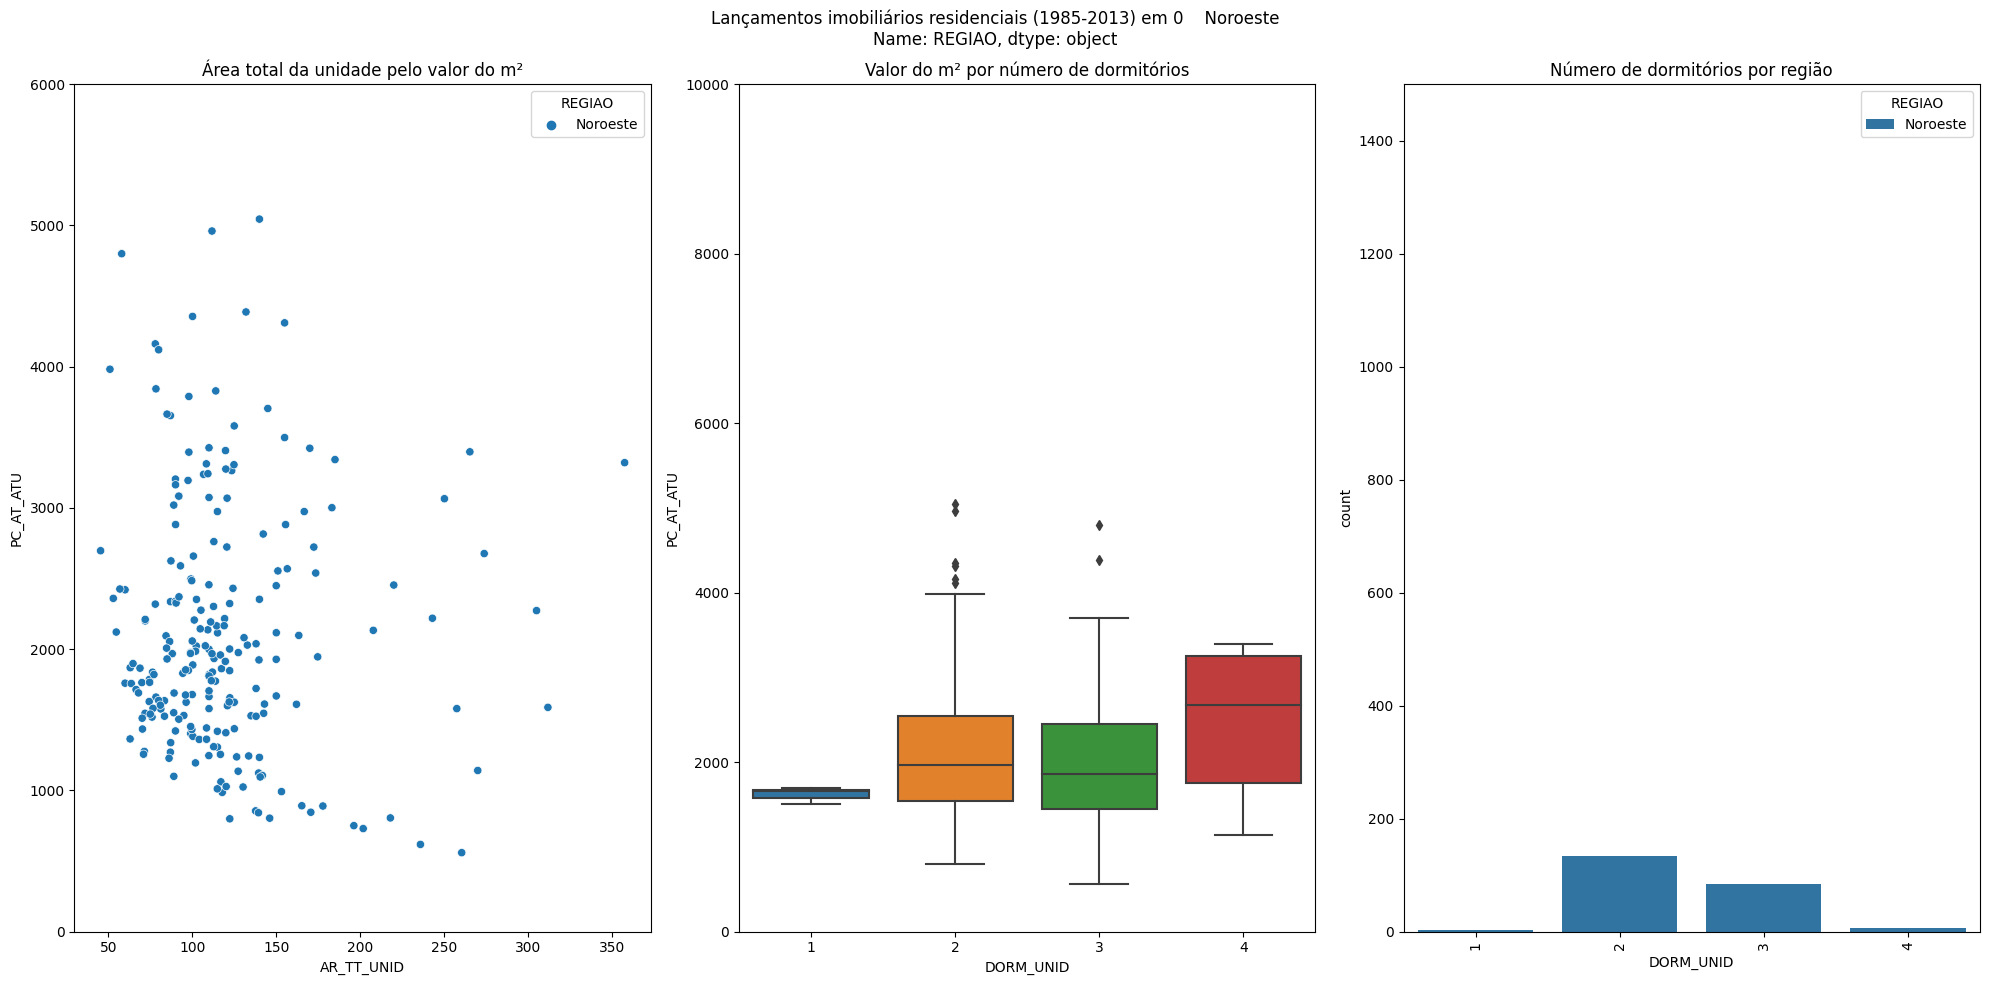

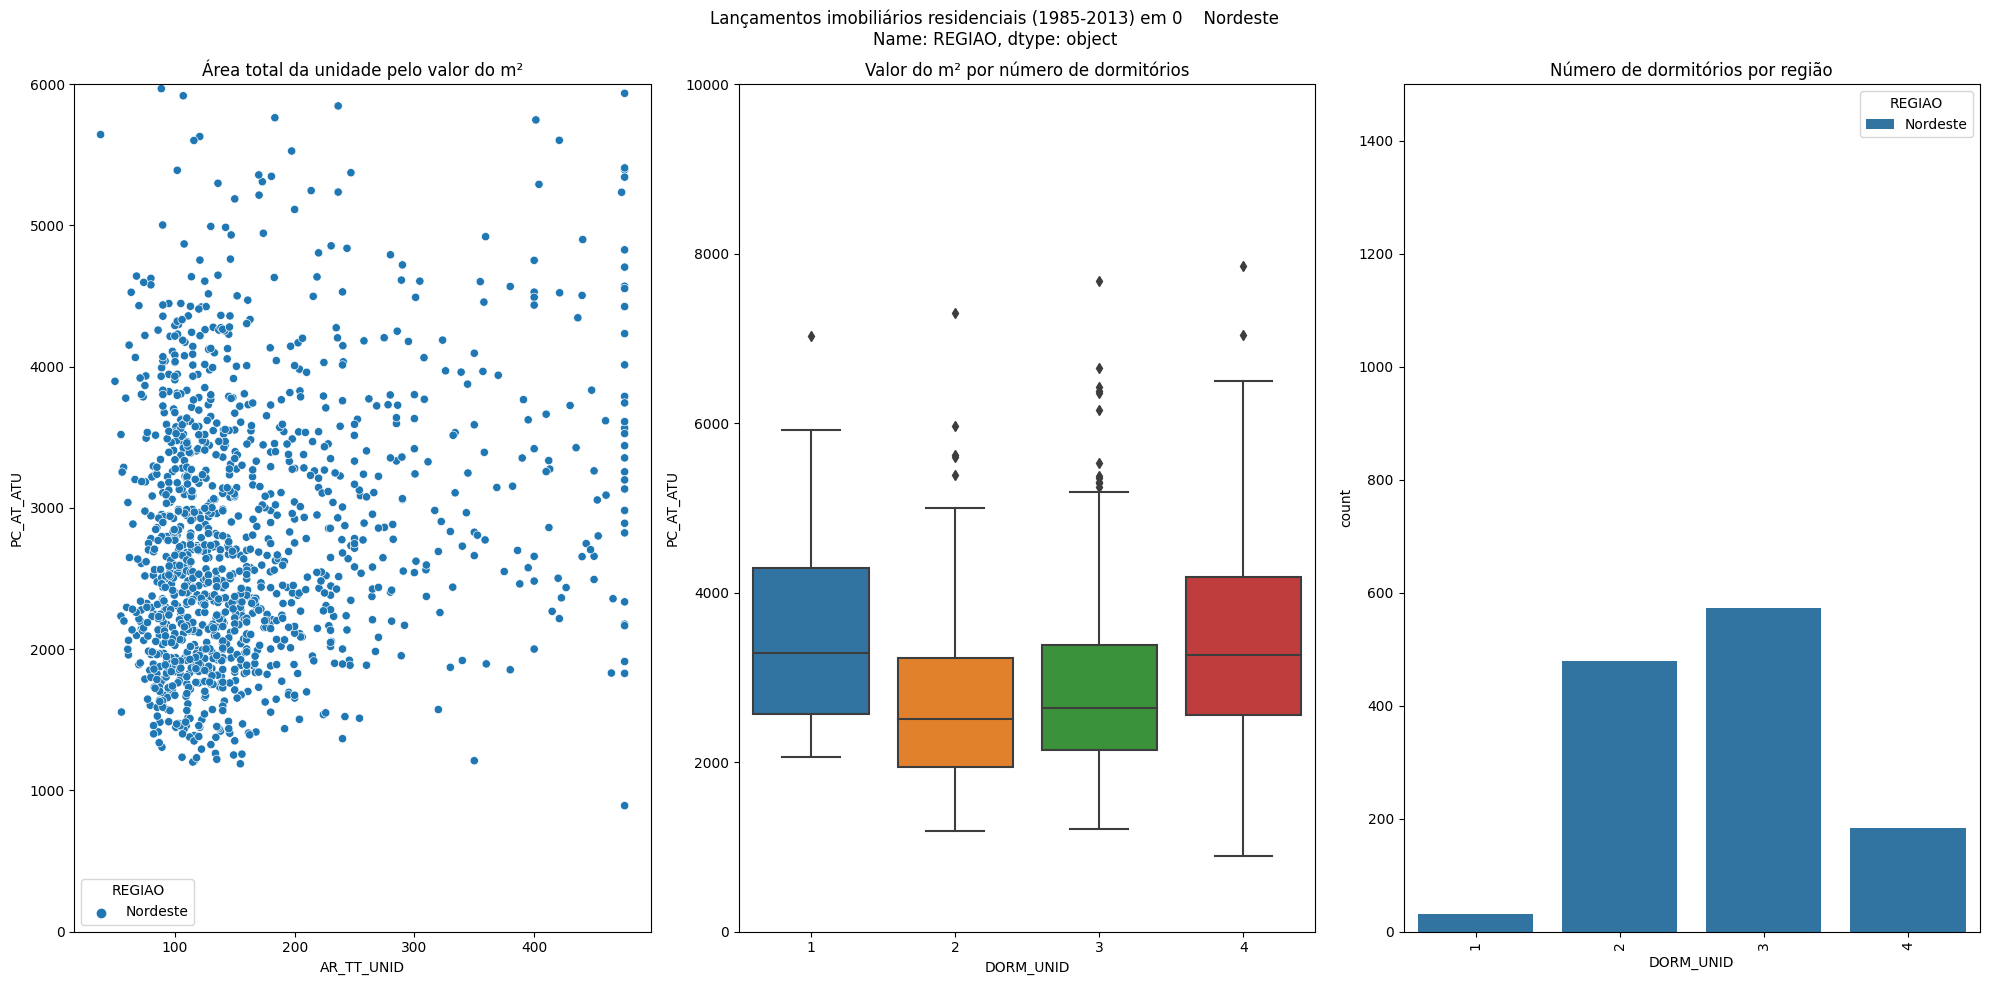

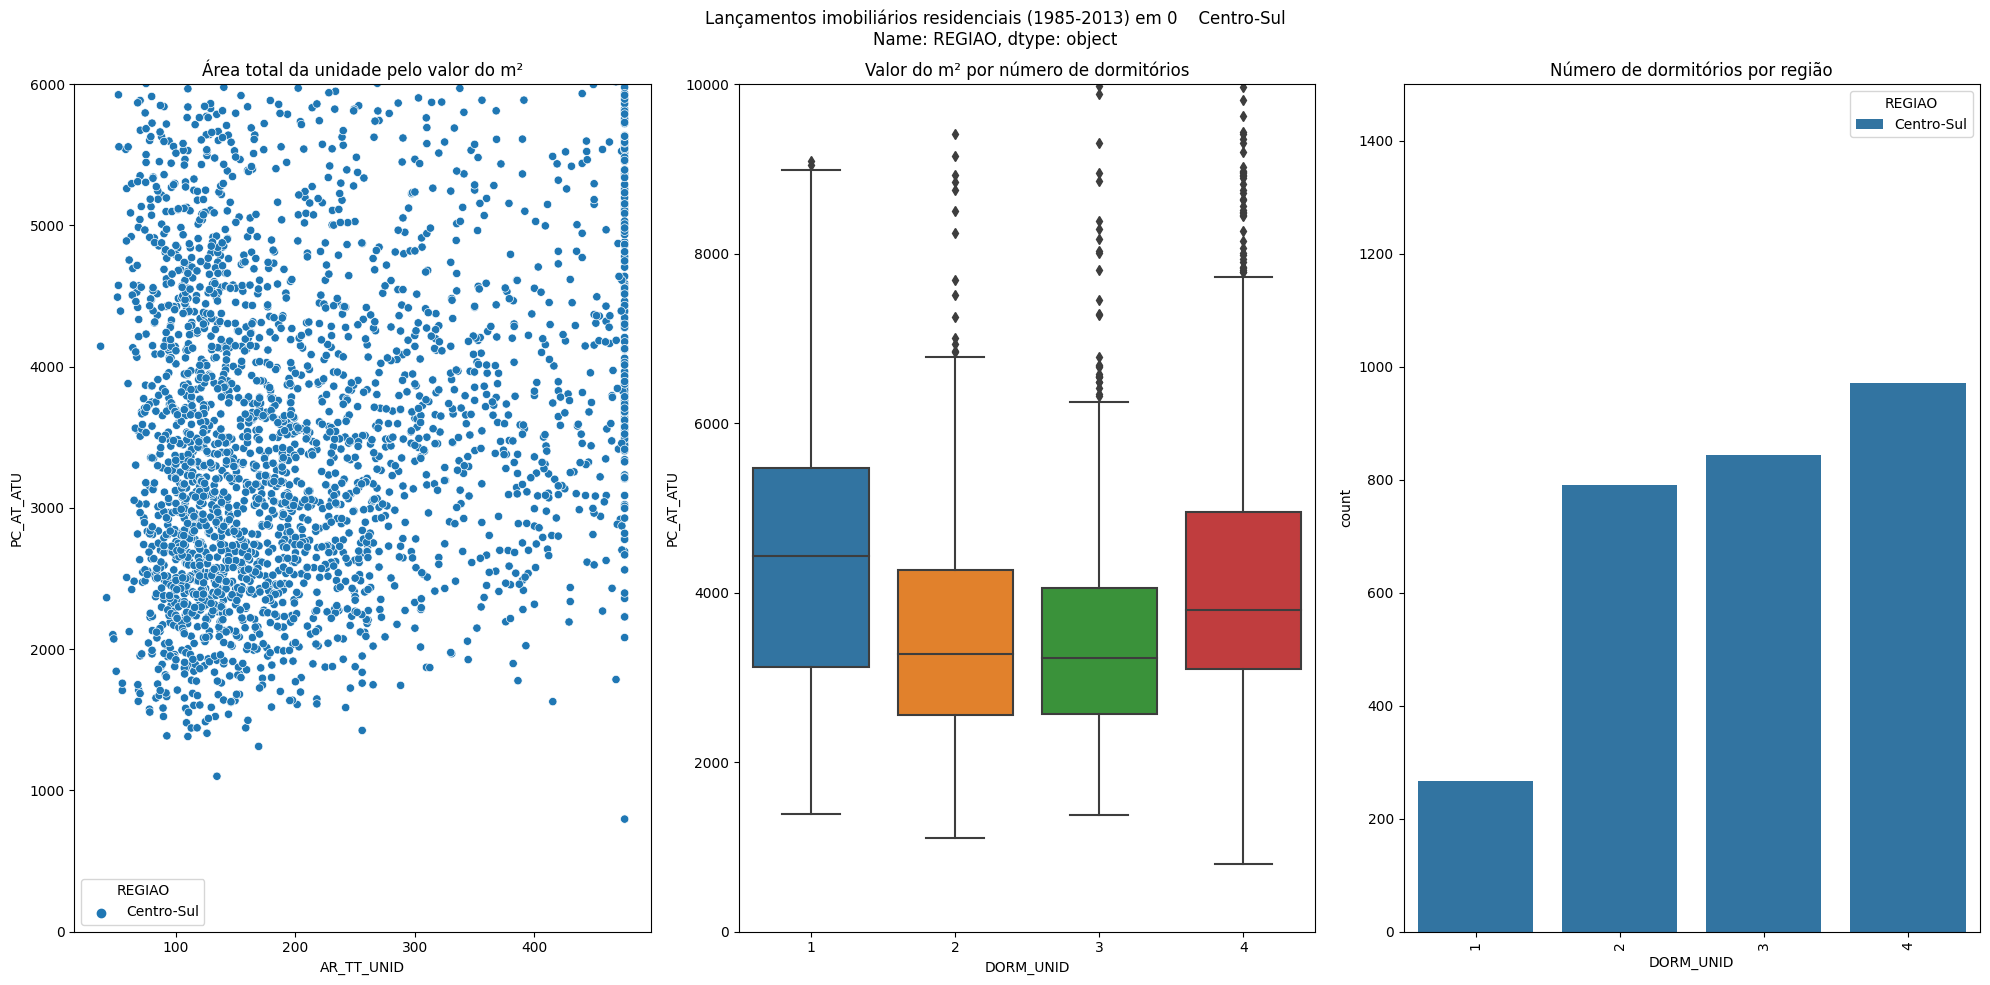

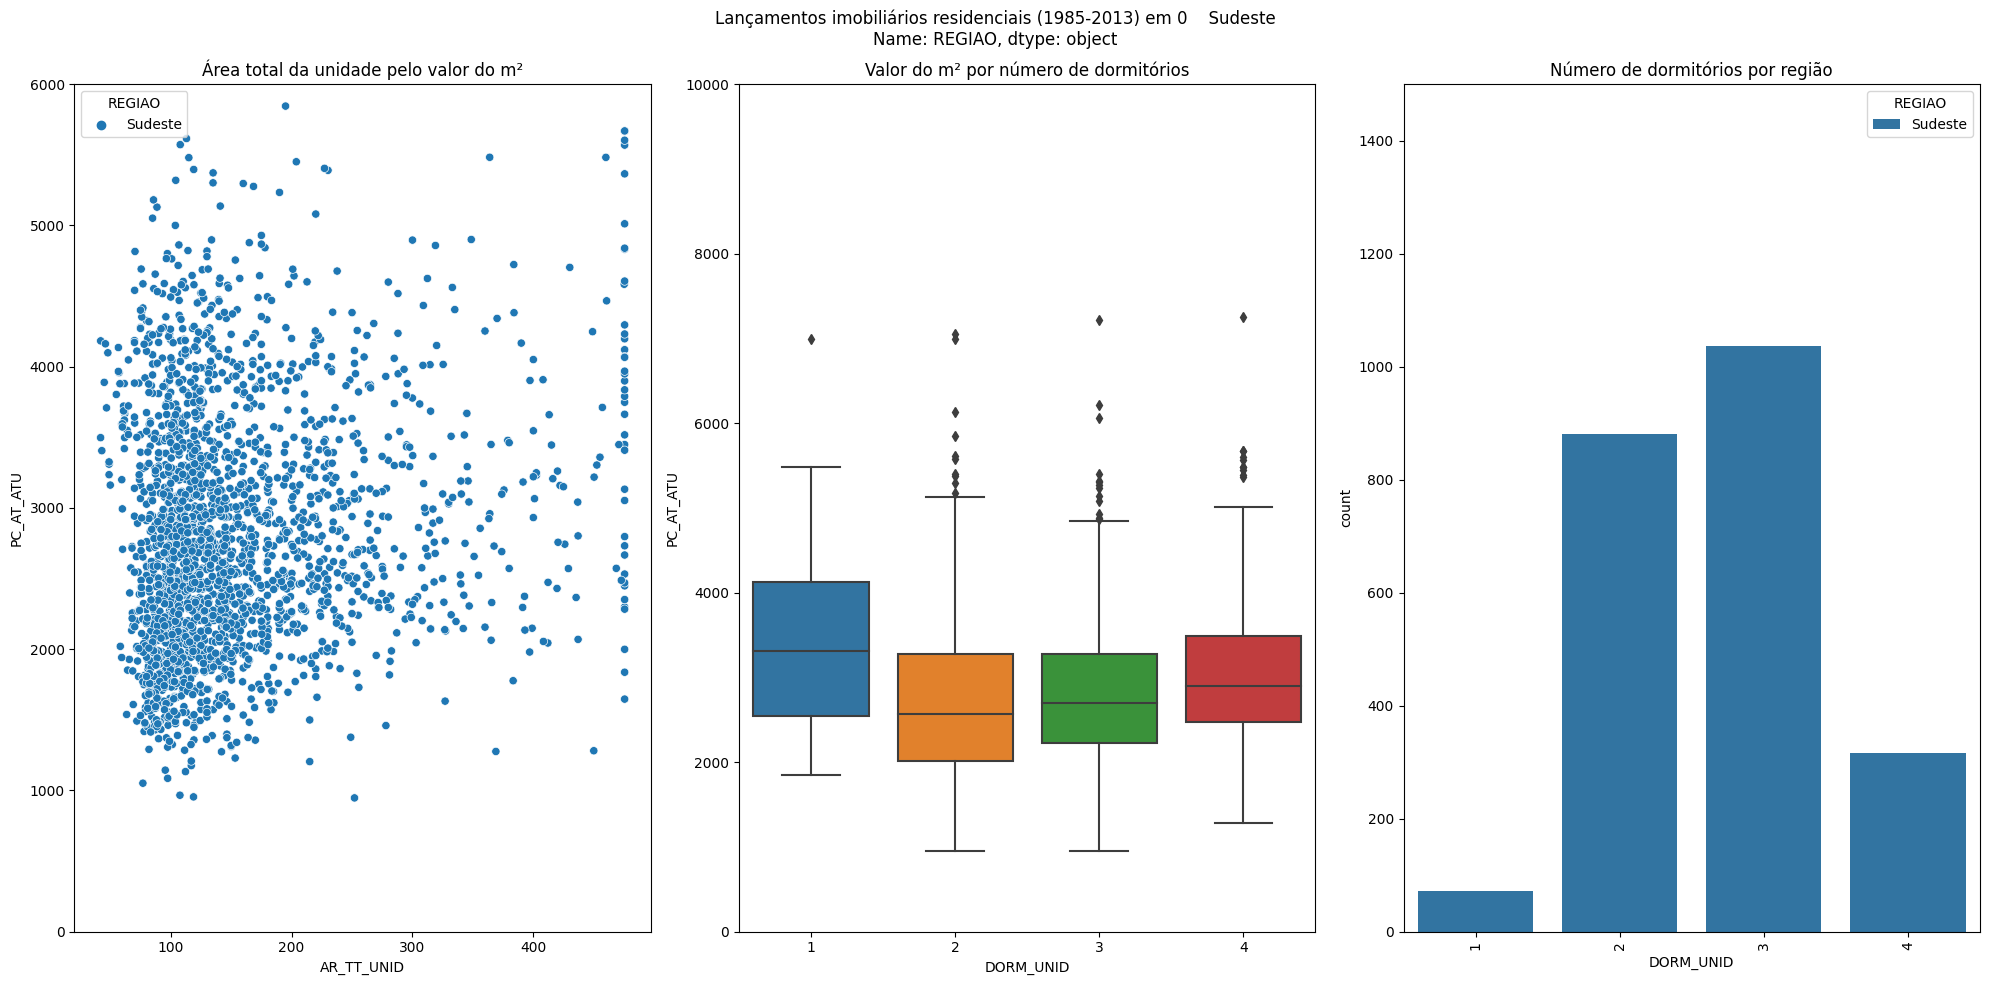

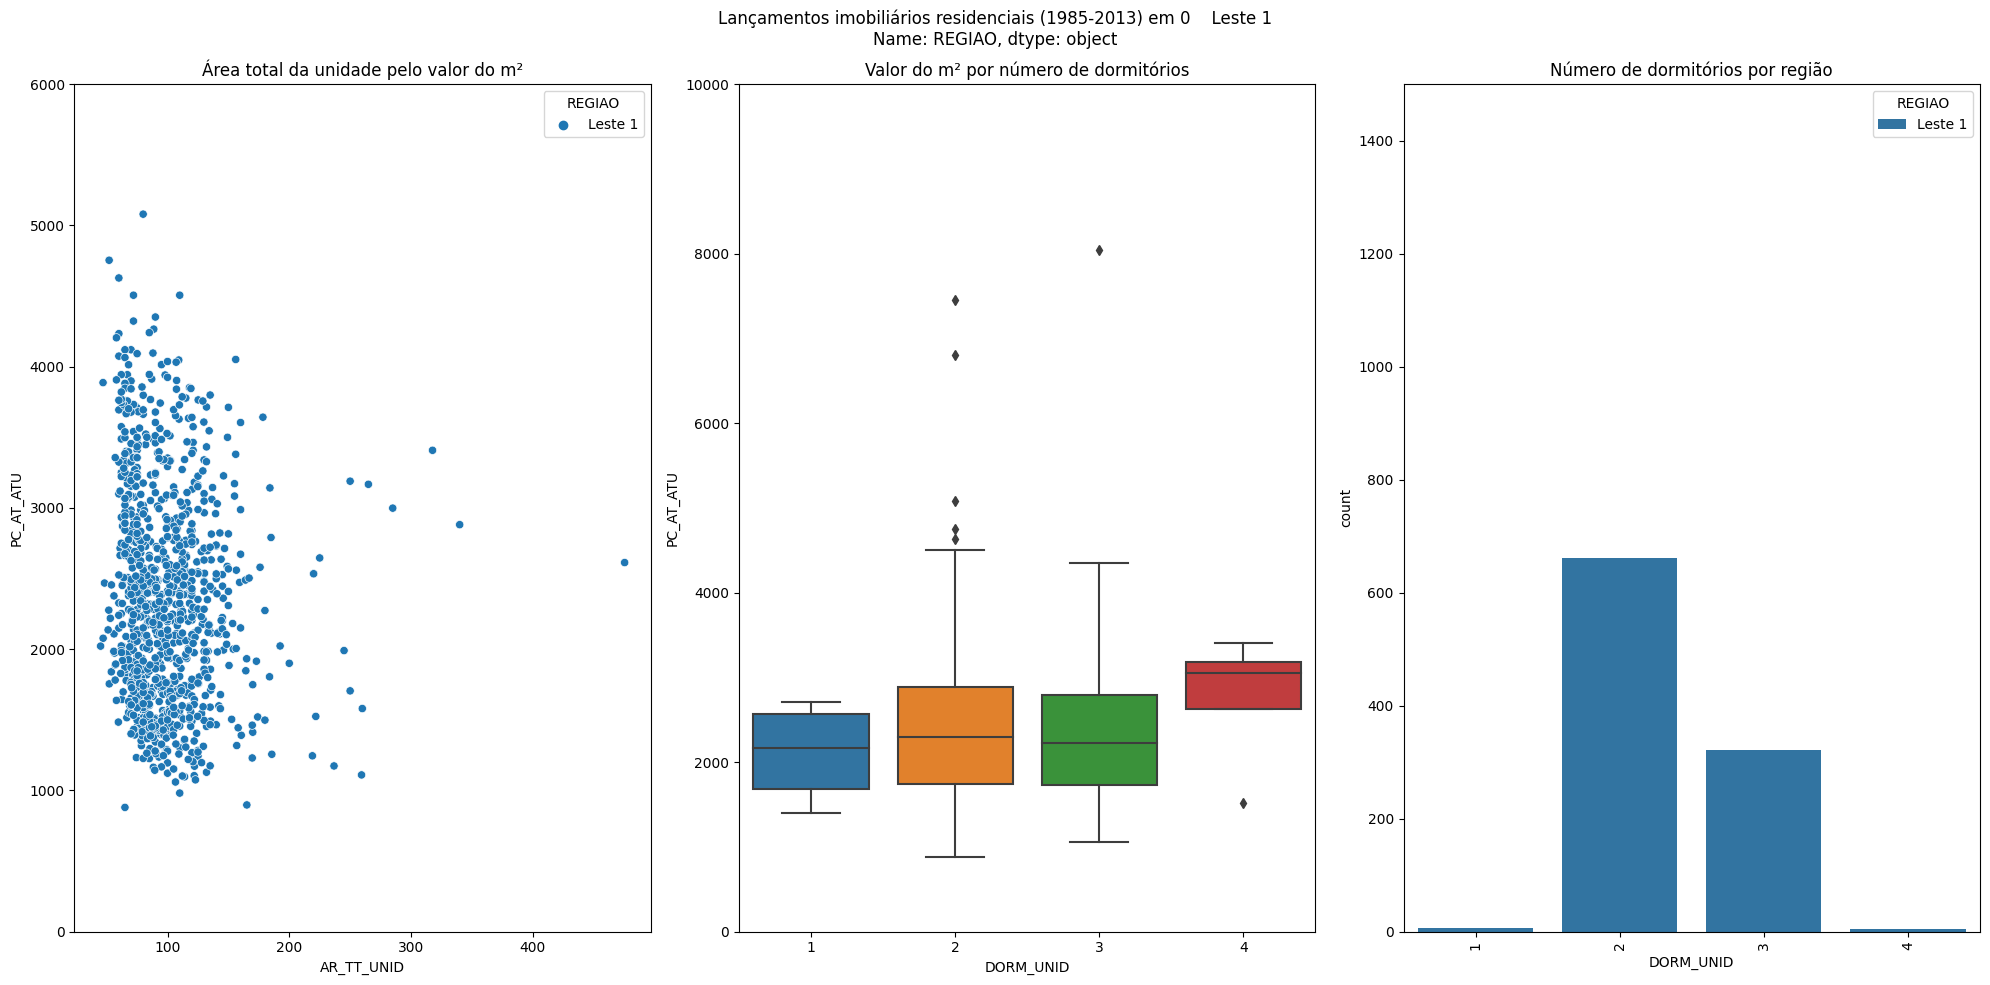

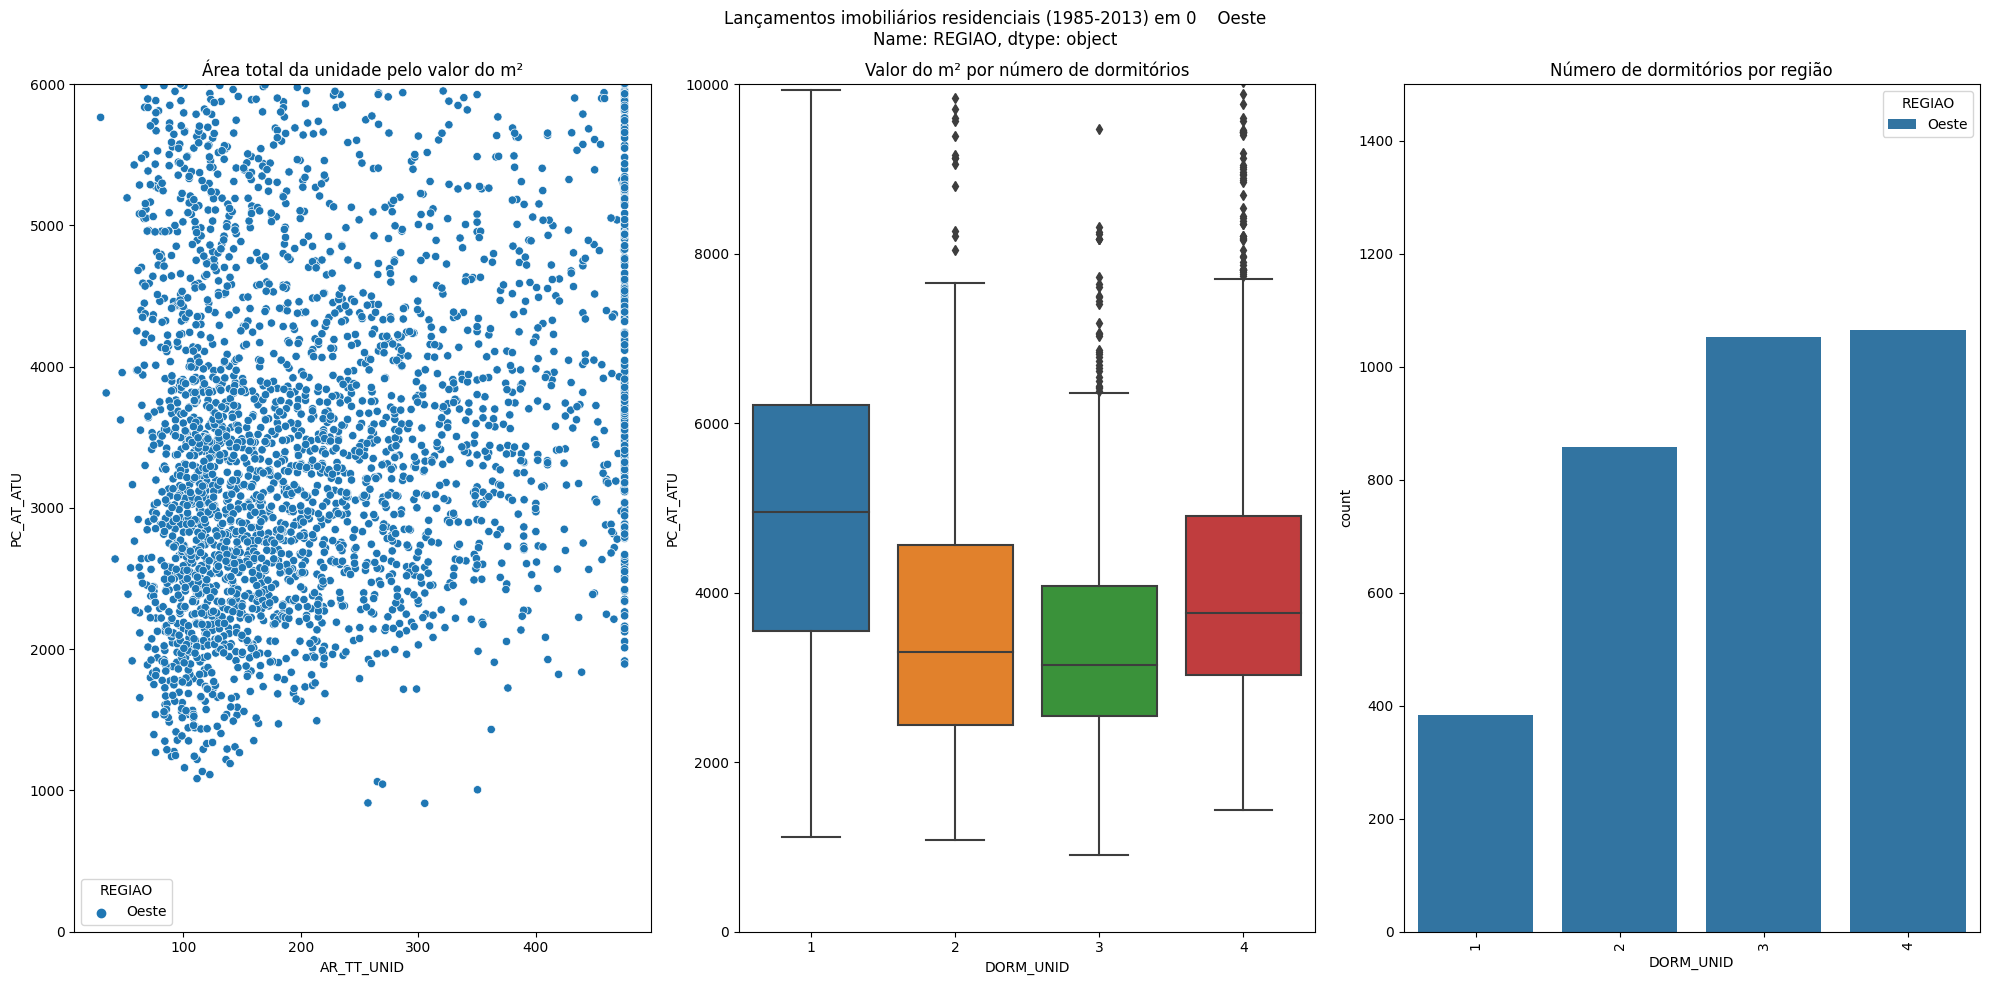

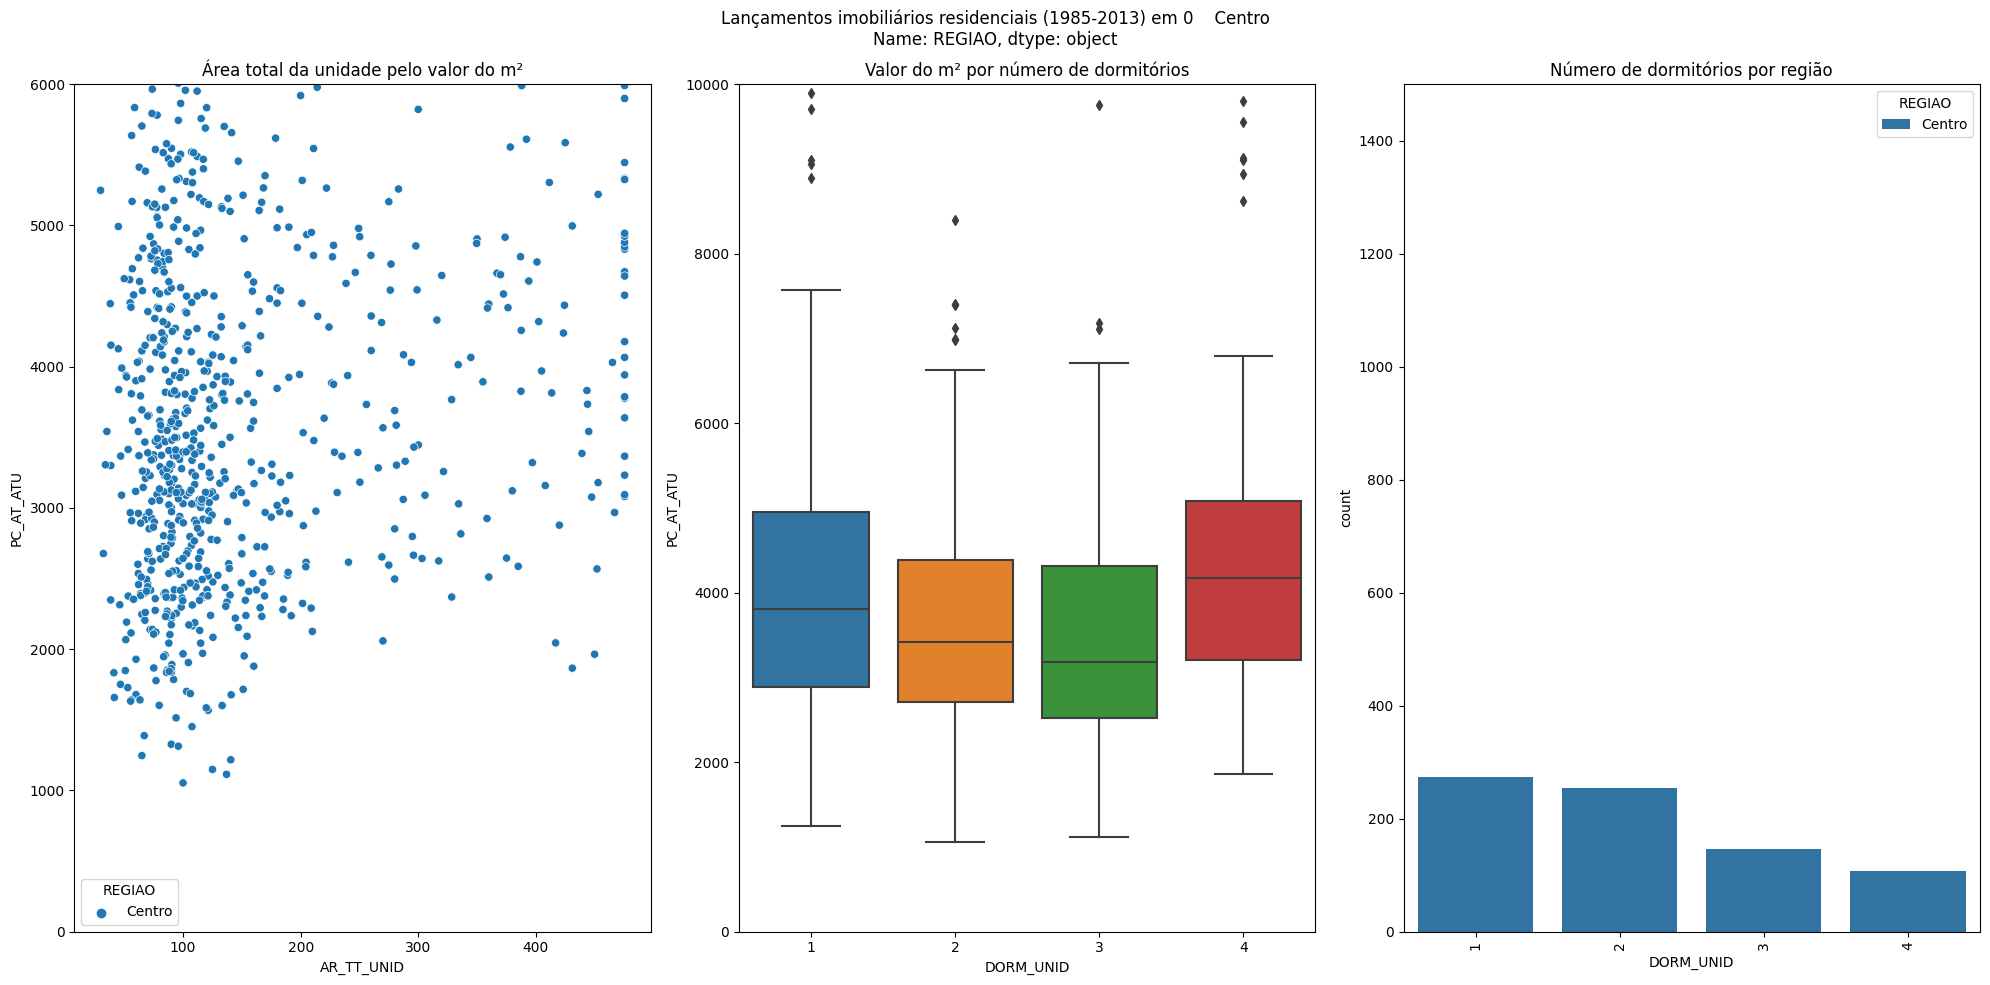

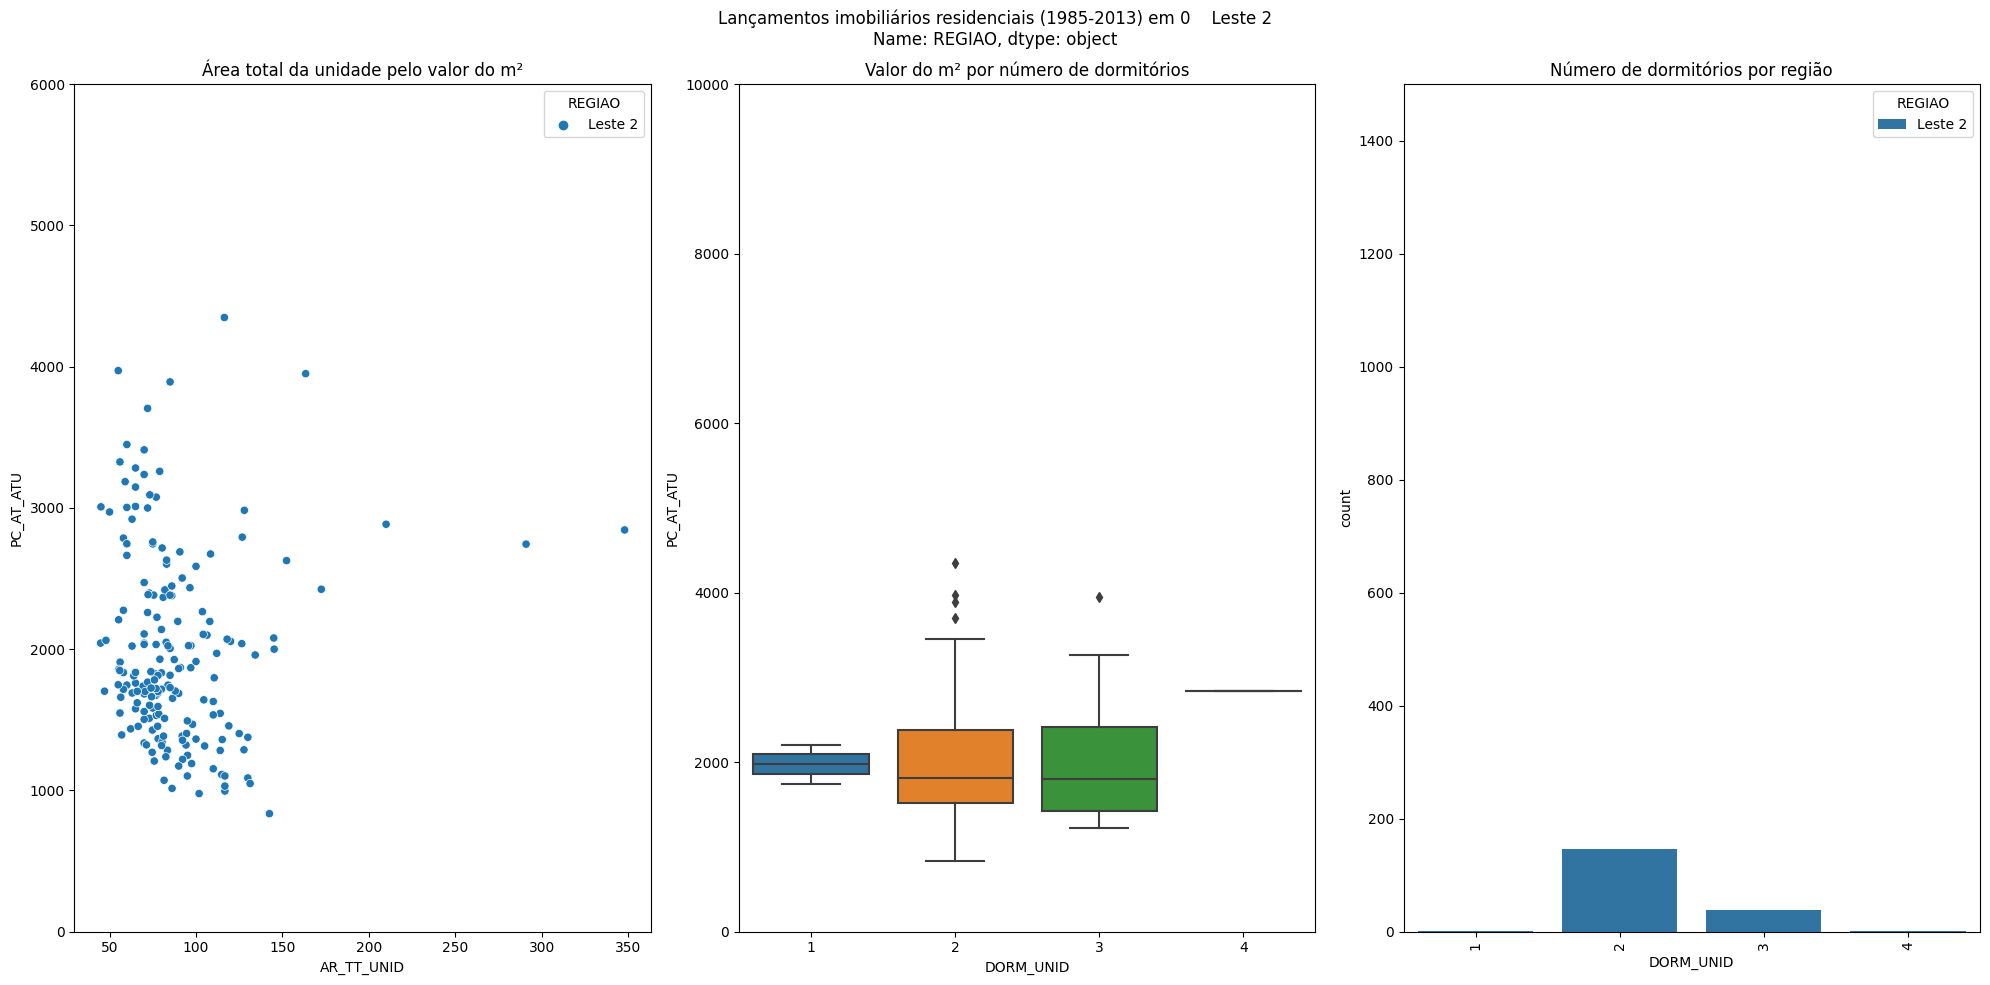

In [69]:
m2_dorm_regiao([df_sul, df_noroeste, df_nordeste, df_centrosul, df_sudeste, df_leste1, df_oeste, df_centro, df_leste2])

<h5>Os tipos de empreendimentos são diferentes por região. Muitos dos empreendimentos lançados nas regiões oeste e centro-sul são para famílias maiores e tem 3 ou 4 dormitórios, enquanto esses modelos aparecem pouco em outras regiões (principalmente os modelos com 4 dormitórios); os empreendimentos com 2 dormitórios parecem ser a aposta mais "segura", uma vez que aparecem em áreas com menor número de empreendimentos. Lançamentos de 1 ou 4 dormitórios tendem a ter o valor do m² maior, enquanto o valor do m² naqueles de 2 ou 3 dormitórios é bem parelho.</h5>

<AxesSubplot: xlabel='REGIAO', ylabel='RENRESP10'>

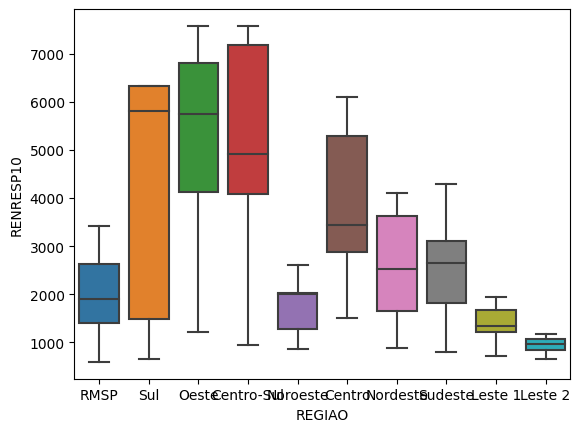

In [51]:
sns.boxplot(y='RENRESP10', data=df, x='REGIAO')

<h5>A renda do responsável é muito distinta em cada região, as regiões com maiores números de empreendimentos também são as com empreendimentos mais caros e as que concentram as maiores rendas. As regiões com as menores rendas possuem poucos lançamentos imobiliários</h5>

<h3>3.2 Analisando os empreendimentos no tempo</h3>

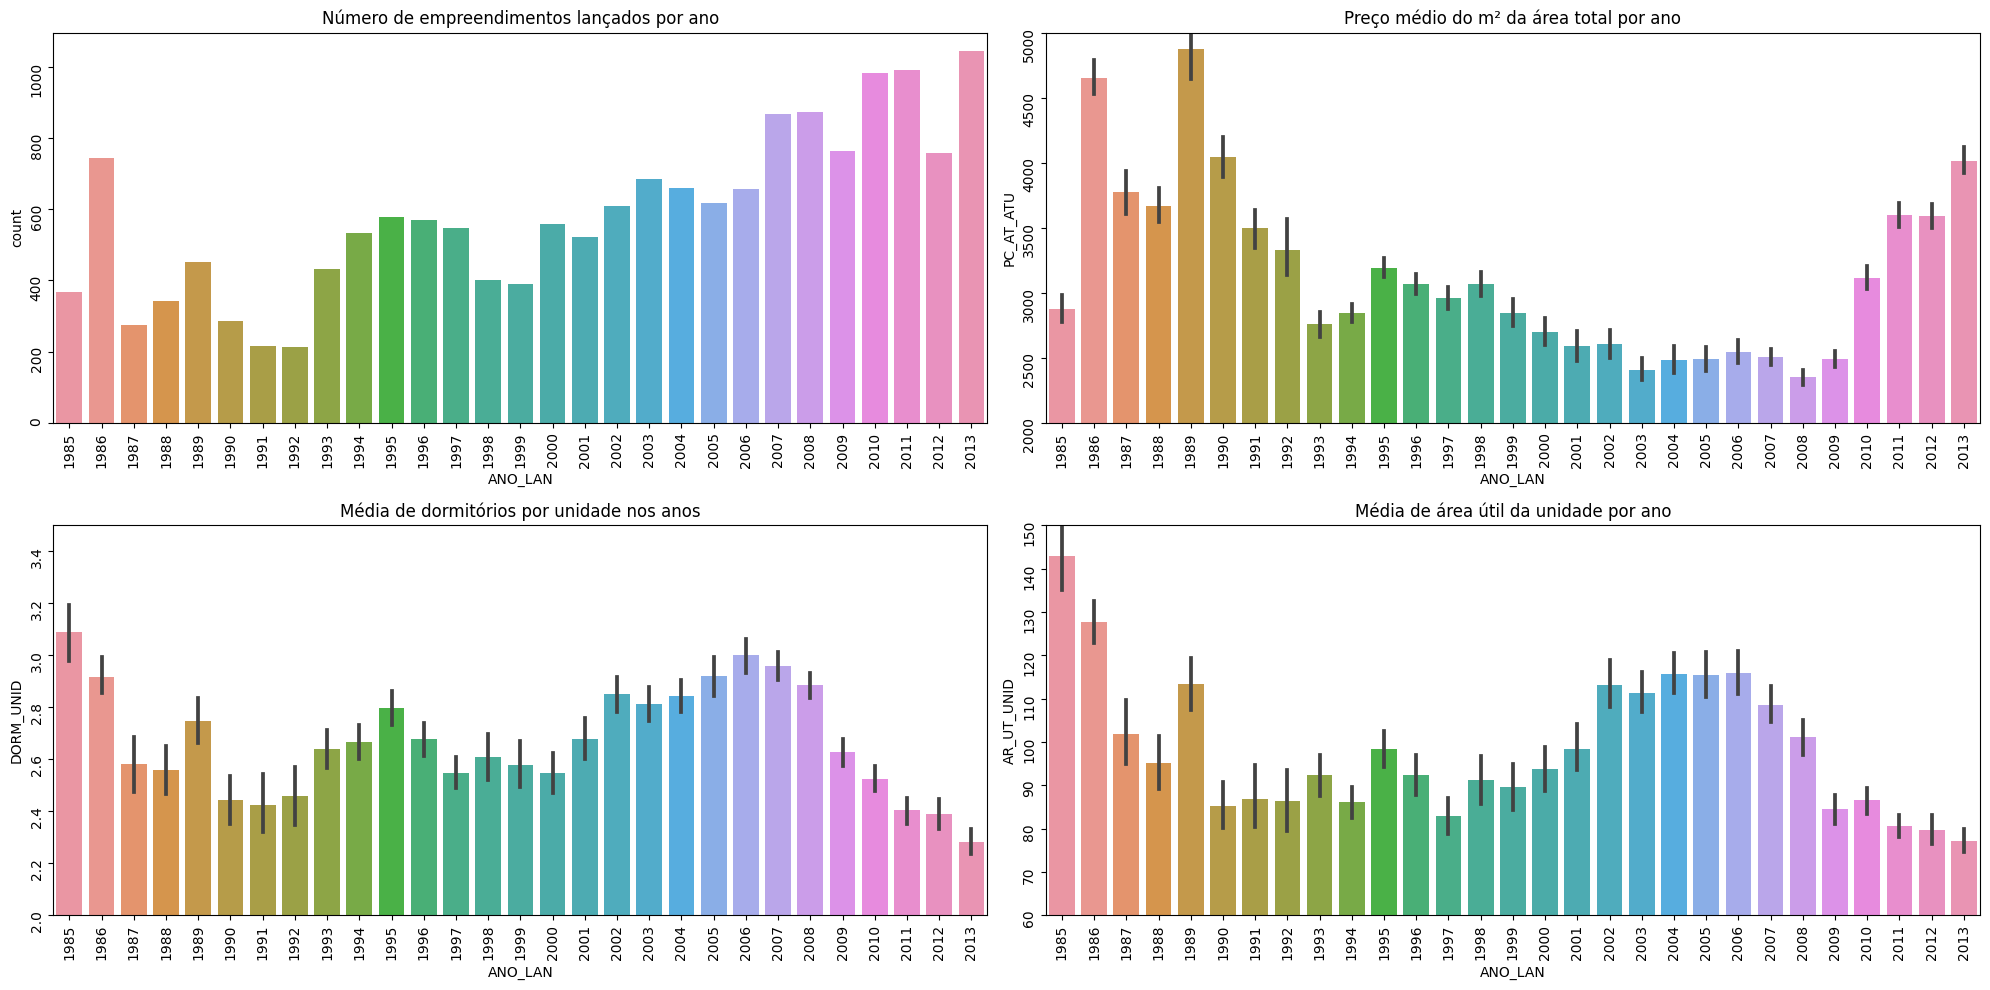

In [52]:
fig, axs = plt.subplots(figsize=(20,10), nrows=2, ncols=2)
emp_ano = sns.countplot(data=df.groupby(df['ANO_LAN']).count(), x=df['ANO_LAN'], ax=axs[0,0])
pc_m2_ano = sns.barplot(y=df['PC_AT_ATU'], x=df['ANO_LAN'], data=df.groupby(df['ANO_LAN']).mean(), ax=axs[0,1])
dorm_ano = sns.barplot(y=df['DORM_UNID'], x=df['ANO_LAN'], data=df.groupby(df['ANO_LAN']).mean(), ax=axs[1,0])
area_util_ano = sns.barplot(y=df['AR_UT_UNID'], x=df['ANO_LAN'], data=df.groupby(df['ANO_LAN']).mean(), ax=axs[1,1])

emp_ano.tick_params(labelrotation = 90)
pc_m2_ano.tick_params(labelrotation = 90)
dorm_ano.tick_params(labelrotation = 90)
area_util_ano.tick_params(labelrotation = 90)

pc_m2_ano.set_ylim(2000,5000)
dorm_ano.set_ylim(2,3.5)
area_util_ano.set_ylim(60,150)

emp_ano.set_title('Número de empreendimentos lançados por ano')
pc_m2_ano.set_title('Preço médio do m² da área total por ano')
dorm_ano.set_title('Média de dormitórios por unidade nos anos')
area_util_ano.set_title('Média de área útil da unidade por ano')

plt.tight_layout()


<h5>Em um geral, o número de lançamentos imobiliários cresceu entre 1985 e 2013, mas as unidades se tornaram consideravelmente menores e com um número menor de quartos, principalmente a partir de 2008. O preço médio do m² foi o menor registrado ao longo da década de 2000, mas tem retomada de crescimento e tendência de ascensão começando em 2010</h5>

<h3>3.3 Correlações com características do entorno</h3>

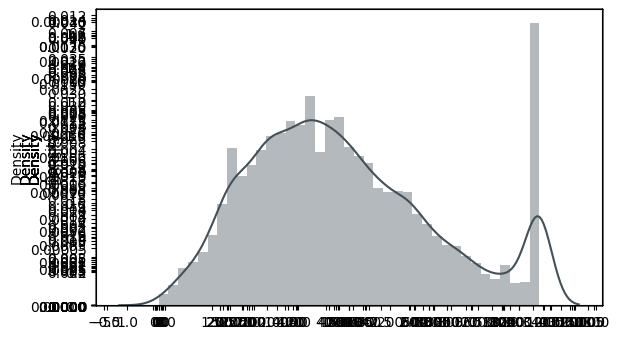

In [77]:
def plot_relacao_censo(dataframe, variaveis, i=0):
    total_plots = len(variaveis)
    fig = plt.figure(figsize=(15,90), facecolor='white')
    fig.subplots_adjust(hspace=0.6, wspace=0.3)

    for var in variaveis:
        ax = fig.add_subplot(total_plots, 2, i+1)
        sns.boxplot(x=dataframe[var], ax=ax, color='#435058')